<a href="https://colab.research.google.com/github/Sachinthana-Pathiranage/Sri-Ayu-Ayurvedic-Care/blob/Pathirana/advanced_outcome_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project's My Component Goal: The project aims to predict the success category and estimated recovery time from user inputs: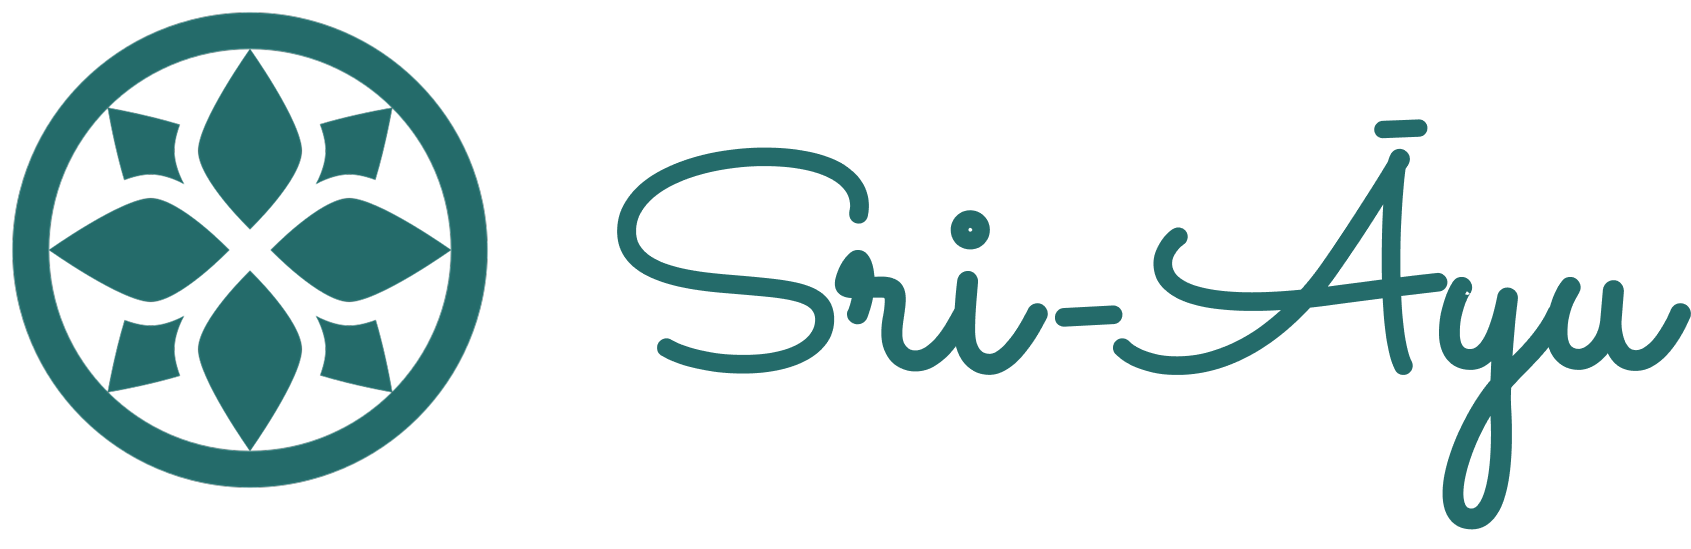**


---


**Workflow: The code follows a typical machine learning pipeline:**


---


Load: Load the dataset.

Clean: Clean and prepare the data for analysis.

EDA: Perform Exploratory Data Analysis to understand the data.

Split: Split the data into training and testing sets.

Preprocess: Apply data transformations like One-Hot Encoding (OHE), Ordinal Encoding, TF-IDF (for text), and scaling.

Initial Evaluate: Train and evaluate various models using cross-validation.

Analyze: Analyze the initial results to identify the best-performing models.

Select Top Candidates: Choose the top 1-2 models for further tuning.

Tune: Fine-tune the selected models' hyperparameters, focusing on
regularization.

Select Best Tuned: Select the best-tuned model.

Final Evaluate: Evaluate the final model on the test set.

Save Artifacts: Save the trained model and other important outputs.

### Core Imports
- **Pandas & Numpy**: Used for data manipulation and numerical operations.
- **Regex**: For regular expressions, often used for text processing.
- **Joblib**: For saving and loading machine learning models.
- **Matplotlib & Seaborn**: For data visualization, creating plots like graphs and charts.
- **Warnings**: Used to manage and suppress warnings.
- **OS & Time**: For handling file system operations and time-related functions.
- **Counter**: From the collections module, useful for counting occurrences of items in a list.
- **WordCloud**: For generating word clouds; an optional library that may be skipped if not available.

### Sklearn Imports
- **Model Selection & Validation**: Includes functions like `train_test_split`, `GridSearchCV`, and cross-validation techniques to split and evaluate models.
- **Preprocessing**: Includes `OneHotEncoder`, `OrdinalEncoder`, and `StandardScaler` for transforming data.
- **Text Processing**: `TfidfVectorizer` for converting text data into numerical features.
- **Imputation & Transformation**: `SimpleImputer` for filling missing data, `ColumnTransformer` and `Pipeline` for combining multiple preprocessing steps.
- **Metrics**: Various functions for assessing model performance, including accuracy, F1 score, and ROC AUC for classification, and metrics like `r2_score` for regression tasks.

### Model Imports
- **Classification Models**: Includes models like `LogisticRegression`, `RandomForestClassifier`, `SVC`, and ensemble methods like `GradientBoostingClassifier` and `LGBMClassifier`.
- **Regression Models**: Includes models such as `Ridge`, `RandomForestRegressor`, `SVR`, and `LGBMRegressor`.
- **Ensemble & XGBoost**: Libraries like `xgboost` and `lightgbm` for powerful boosting methods in both classification and regression tasks.


In [1]:
"""
Advanced Treatment Outcome Prediction (V5.4 - Fixing Tuning & Selection Logic)

Pipeline: Load -> Clean -> EDA -> Split -> Preprocess (OHE/Ordinal/TF-IDF/Scale) ->
          Initial Evaluate (Diverse Models + CV) -> Analyze ->
          Select Top 1-2 Candidates -> Tune (Regularization Focus) ->
          Select Best Tuned -> Final Evaluate -> Save Artifacts
"""

# --- Core Imports ---
import pandas as pd
import numpy as np
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import time
import math
from collections import Counter
# Ensure WordCloud is installed: pip install wordcloud
try:
    from wordcloud import WordCloud
except ImportError:
    print("\033[93mWordCloud library not found. Skipping word cloud plot. Install with: pip install wordcloud\033[0m")
    WordCloud = None

# --- Sklearn Imports ---
from sklearn.model_selection import (
    train_test_split, GridSearchCV, cross_validate,
    StratifiedKFold, KFold, learning_curve
)
from sklearn.preprocessing import (
    OneHotEncoder, OrdinalEncoder, StandardScaler
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    # Classification
    accuracy_score, classification_report, confusion_matrix, log_loss,
    f1_score, balanced_accuracy_score, precision_score, recall_score, roc_auc_score,
    # Regression
    mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
)
from sklearn.metrics import roc_auc_score as roc_auc_score_multiclass
from sklearn.exceptions import NotFittedError

# --- Model Imports ---
# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
# Regression
from sklearn.linear_model import Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb_reg
from lightgbm import LGBMRegressor
from sklearn.svm import SVR, LinearSVR


### Configuration & Setup
- **Warnings**: Suppresses `UserWarning` and `FutureWarning` to avoid clutter in the output.
- **Pandas Settings**: Configures Pandas to display all columns and set a wide output width for better data visibility.
- **Output Directory**: Creates a directory named `advanced_treatment_models_final_v5_4` to store results.
- **Random Seed**: Sets the random seed to ensure reproducibility.
- **Plotting Style**: Configures Seaborn's `viridis` color palette and `seaborn-v0_8-talk` style for consistent visual aesthetics.

### ANSI Color Codes
- Defines a dictionary of color codes for colored output in the terminal, improving readability with headers and error messages.

### Helper Function: Format Recovery Time
- **`format_recovery_range`**: A function to format recovery times into human-readable categories, handling different ranges of predicted days.

### 1. Load Data
- **Data Loading**: Attempts to load an Excel file, cleans up column names, and checks if the necessary column `'Treatment_English_Name'` exists.
- **Error Handling**: Catches `FileNotFoundError`, `KeyError`, and other exceptions to provide meaningful error messages.

### 2. Initial Data Cleaning & Feature Engineering
- **Success Category Encoding**: Converts the `Success_Category` into numerical values using a predefined mapping and drops rows with missing values in the `Success_Category_Encoded` column.
- **Recovery Time Processing**: Converts the `Recovery_Time` into a numerical format by extracting numeric values and averaging where necessary.
- **Text Cleaning**: The `Symptoms` column is cleaned by removing non-alphanumeric characters and extra spaces to prepare for text-based analysis.
- **Feature Engineering**: Creates new columns such as `Symptoms_Word_Count`, `Disease_Cleaned`, `Treatment_Cleaned`, and ensures that `Severity` is properly formatted for encoding.



In [2]:
# --- Configuration & Setup ---
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1200)
output_dir = "advanced_treatment_models_final_v5_4" # Updated directory
os.makedirs(output_dir, exist_ok=True)
SEED = 42
plt.style.use('seaborn-v0_8-talk')
sns.set_palette("viridis")
print(f"Output directory: {output_dir}")
print(f"Random Seed: {SEED}")

# --- ANSI Color Codes ---
COLOR = { "HEADER": "\033[95m", "BLUE": "\033[94m", "GREEN": "\033[92m", "YELLOW": "\033[93m", "RED": "\033[91m", "BOLD": "\033[1m", "UNDERLINE": "\033[4m", "END": "\033[0m", }

# --- Helper Function: Format Recovery Time ---
def format_recovery_range(predicted_days_float):
    if pd.isna(predicted_days_float) or predicted_days_float <= 0: return "Immediate / < 1 day"
    elif predicted_days_float <= 1.0: return "About 1 day"
    else: lower = math.floor(predicted_days_float); upper = math.ceil(predicted_days_float); lower = max(1, lower); upper = max(lower, upper); return f"{lower} days" if lower == upper else f"{lower}-{upper} days"

# --- 1. Load Data ---
print(f"\n{COLOR['BOLD']}{COLOR['HEADER']}--- (1) Loading Data ---{COLOR['END']}")
file_path = "/content/sachinthana_dataset_new.xlsx"
try:
    df = pd.read_excel(file_path, sheet_name='Sheet1')
    print(f"Dataset loaded successfully. Initial Shape: {df.shape}")
    df.columns = df.columns.str.strip().str.replace(r'[()]+', '', regex=True).str.replace(' ', '_', regex=False)
    print(f"Cleaned columns: {df.columns.tolist()}")
    if 'Treatment_English_Name' not in df.columns: raise KeyError("Column 'Treatment_English_Name' not found after cleaning.")
    print(f"\nInitial head:\n{df.head().to_string()}")
except FileNotFoundError: print(f"{COLOR['RED']}FATAL: File not found at {file_path}{COLOR['END']}"); exit()
except KeyError as e: print(f"{COLOR['RED']}FATAL: Missing expected column: {e}{COLOR['END']}"); exit()
except Exception as e: print(f"{COLOR['RED']}FATAL: Error loading Excel file: {e}{COLOR['END']}"); exit()

# --- 2. Initial Data Cleaning & Feature Engineering ---
print(f"\n{COLOR['BOLD']}{COLOR['HEADER']}--- (2) Initial Data Cleaning & Feature Engineering ---{COLOR['END']}")
severity_categories = ['Mild', 'Moderate', 'Severe']
success_map = {'Low': 0, 'Medium': 1, 'High': 2}; reverse_success_map = {v: k for k, v in success_map.items()}
df['Success_Category_Encoded'] = df['Success_Category'].map(success_map)
initial_rows = df.shape[0]; df.dropna(subset=['Success_Category_Encoded'], inplace=True); rows_dropped = initial_rows - df.shape[0]
if rows_dropped > 0: print(f"{COLOR['YELLOW']}Warning: Dropped {rows_dropped} rows with missing Success_Category.{COLOR['END']}")
df['Success_Category_Encoded'] = df['Success_Category_Encoded'].astype(int)
print(f"Target 'Success_Category_Encoded' created. Shape after dropna: {df.shape}")
print("Success Category Distribution:\n", df['Success_Category_Encoded'].map(reverse_success_map).value_counts(normalize=True).round(3))
def convert_recovery_time(value): # Ensure function is defined here
    if pd.isna(value): return np.nan
    value_str = re.sub(r"[–—]", "-", str(value).strip())
    try: numbers = [float(num) for num in re.findall(r'\d+\.?\d*', value_str)]; return np.mean(numbers) if len(numbers) == 2 else (numbers[0] if len(numbers) == 1 else np.nan)
    except: return np.nan
df['Recovery_Time_Processed'] = df['Recovery_Time'].apply(convert_recovery_time)
nans_recovery = df['Recovery_Time_Processed'].isna().sum()
print(f"Target 'Recovery_Time_Processed' created. NaNs: {nans_recovery} ({nans_recovery/df.shape[0]*100:.1f}%)")
def clean_text(text):
    if pd.isna(text): return ""
    text = str(text).lower(); text = re.sub(r'[^\w\s-]', '', text); text = re.sub(r'\s+', ' ', text).strip()
    return text
df['Symptoms_Cleaned'] = df['Symptoms'].apply(clean_text)
df['Symptoms_Word_Count'] = df['Symptoms_Cleaned'].apply(lambda x: len(x.split()) if x else 0) # Keep for EDA
df['Disease_Cleaned'] = df['Disease'].astype(str).str.strip().str.lower()
df['Treatment_Cleaned'] = df['Treatment_English_Name'].astype(str).str.strip()
df['Severity'] = df['Severity'].astype(str).str.strip() # Keep as string for OrdinalEncoder input

Output directory: advanced_treatment_models_final_v5_4
Random Seed: 42

--- (1) Loading Data ---
Dataset loaded successfully. Initial Shape: (225, 7)
Cleaned columns: ['Treatment_Sinhala_Name', 'Treatment_English_Name', 'Symptoms', 'Severity', 'Recovery_Time', 'Success_Category', 'Disease']

Initial head:
  Treatment_Sinhala_Name    Treatment_English_Name                             Symptoms  Severity Recovery_Time Success_Category     Disease
0    බ්රහ්මී-අශ්වගන්ධ තේ    Brahmi-Ashwagandha Tea    Throbbing pain, light sensitivity  Moderate      5–7 days           Medium  Migraine  
1        පිඬා තෙල් නාස්ය        Pinda Thaila Nasya             One-sided pain, vomiting    Severe    10–14 days              Low  Migraine  
2         ගොටුකොල පේස්ට්            Gotukola Paste             Dull headache, dizziness      Mild      3–5 days             High  Migraine  
3          සපු පත්ර පානය        Sapu Leaf Infusion           Tension headaches, fatigue      Mild      2–4 days             High 

### 3.1 Target Variable Analysis
In this section, we analyze the target variables: `Success_Category` and `Recovery_Time`.

- **Success Category Distribution**: This plot shows the distribution of the `Success_Category` variable, which represents the level of success of the treatment. It uses a count plot to display the counts of different success levels (Low, Medium, High).
  
- **Recovery Time Distribution**: This plot visualizes the distribution of `Recovery_Time_Processed`, which represents the time taken for a patient to recover. A histogram is used, with additional lines to highlight the mean and median values of recovery time. This helps in understanding the general trend of recovery time across the dataset.

---

### 3.2 Feature Distributions
This section explores the distribution of several key features in the dataset: `Severity`, `Disease`, `Treatment`, and `Symptoms_Word_Count`.

- **Severity Distribution**: A count plot is used to show the distribution of the `Severity` feature, which indicates the severity of the condition (e.g., Mild, Moderate, Severe).
  
- **Top Diseases and Treatments**: Bar plots display the top 15 most common diseases and treatments in the dataset. This gives insights into the most frequent conditions and medical approaches in the dataset.

- **Symptom Word Count Distribution**: A histogram of the `Symptoms_Word_Count` feature, showing the distribution of the number of words in the cleaned symptom descriptions. This provides an understanding of how detailed the symptom descriptions are across cases.

---

### 3.3 Feature vs. Target Relationships
This section investigates how the features relate to the target variables (`Success_Category` and `Recovery_Time_Processed`).

- **Success Category vs. Severity**: A count plot shows how `Severity` is distributed across the different `Success_Category` levels. This helps assess how treatment success is related to severity.

- **Success Category vs. Top Diseases**: A stacked bar plot is used to show the proportion of `Success_Category` across the top diseases. It helps understand how different diseases are associated with different treatment outcomes.

- **Recovery Time vs. Severity**: A violin plot is used to show how `Recovery_Time_Processed` varies across different severity levels. This helps in identifying if more severe conditions tend to have longer recovery times.

- **Recovery Time vs. Diseases and Treatments**: Box plots are used to explore how `Recovery_Time_Processed` is distributed across the top diseases and treatments. These plots reveal the variability of recovery times for different diseases and treatments.

- **Recovery Time vs. Symptom Word Count**: A scatter plot with a regression line is used to show the relationship between the number of words in the symptoms description and the recovery time. This helps identify if there's any correlation between the detail in the symptoms and the time taken to recover.

---

### 3.4 Initial Correlation Check
This section examines the correlation between numeric features (`Severity`, `Symptoms_Word_Count`, `Success_Category_Encoded`, and `Recovery_Time_Processed`).

- **Correlation Matrix**: A heatmap is generated to show the correlations between the selected numeric features. It helps understand the linear relationships between these variables, with the correlation values annotated for easier interpretation.



--- (3) Enhanced Exploratory Data Analysis ---

--- 3.1 Target Variable Analysis ---


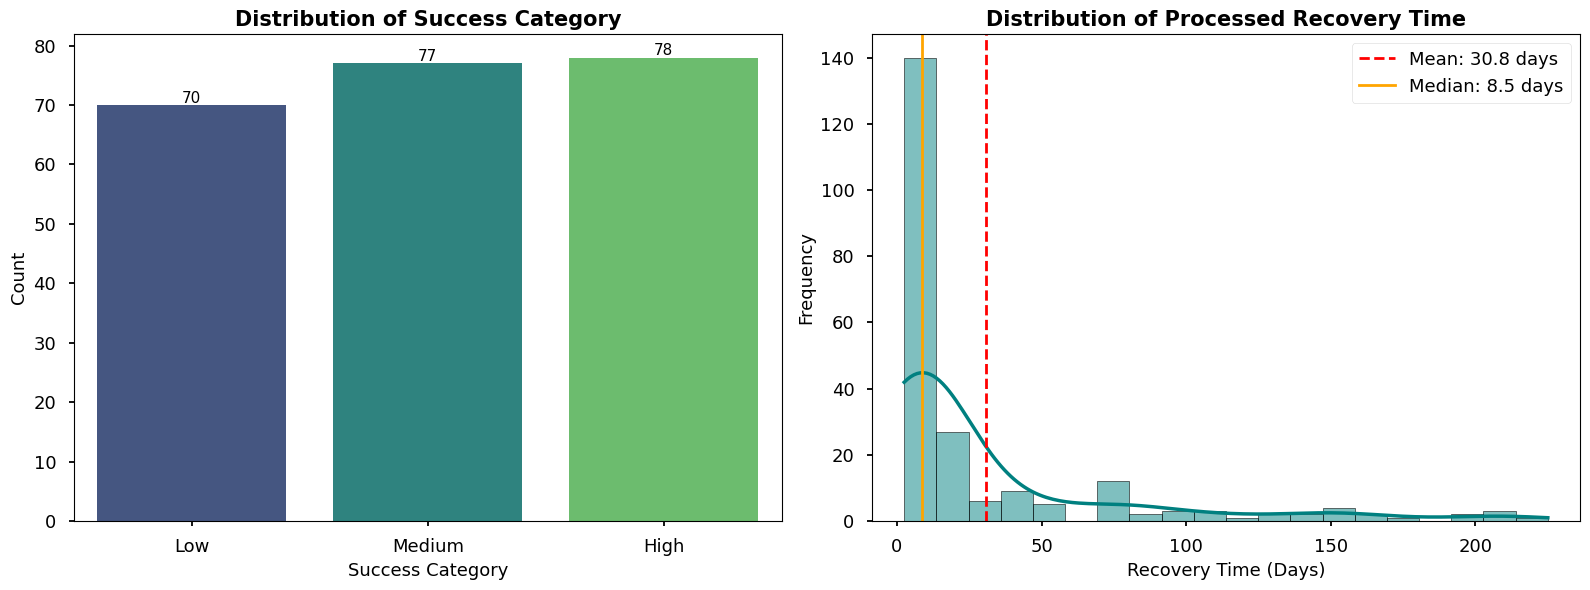


--- 3.2 Feature Distributions ---


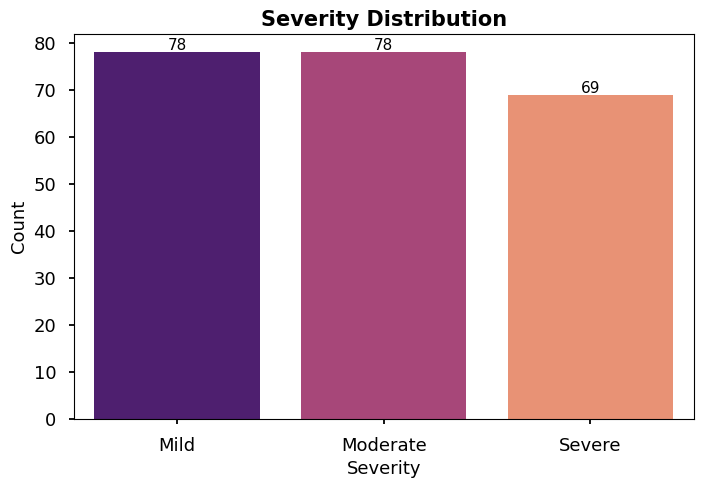

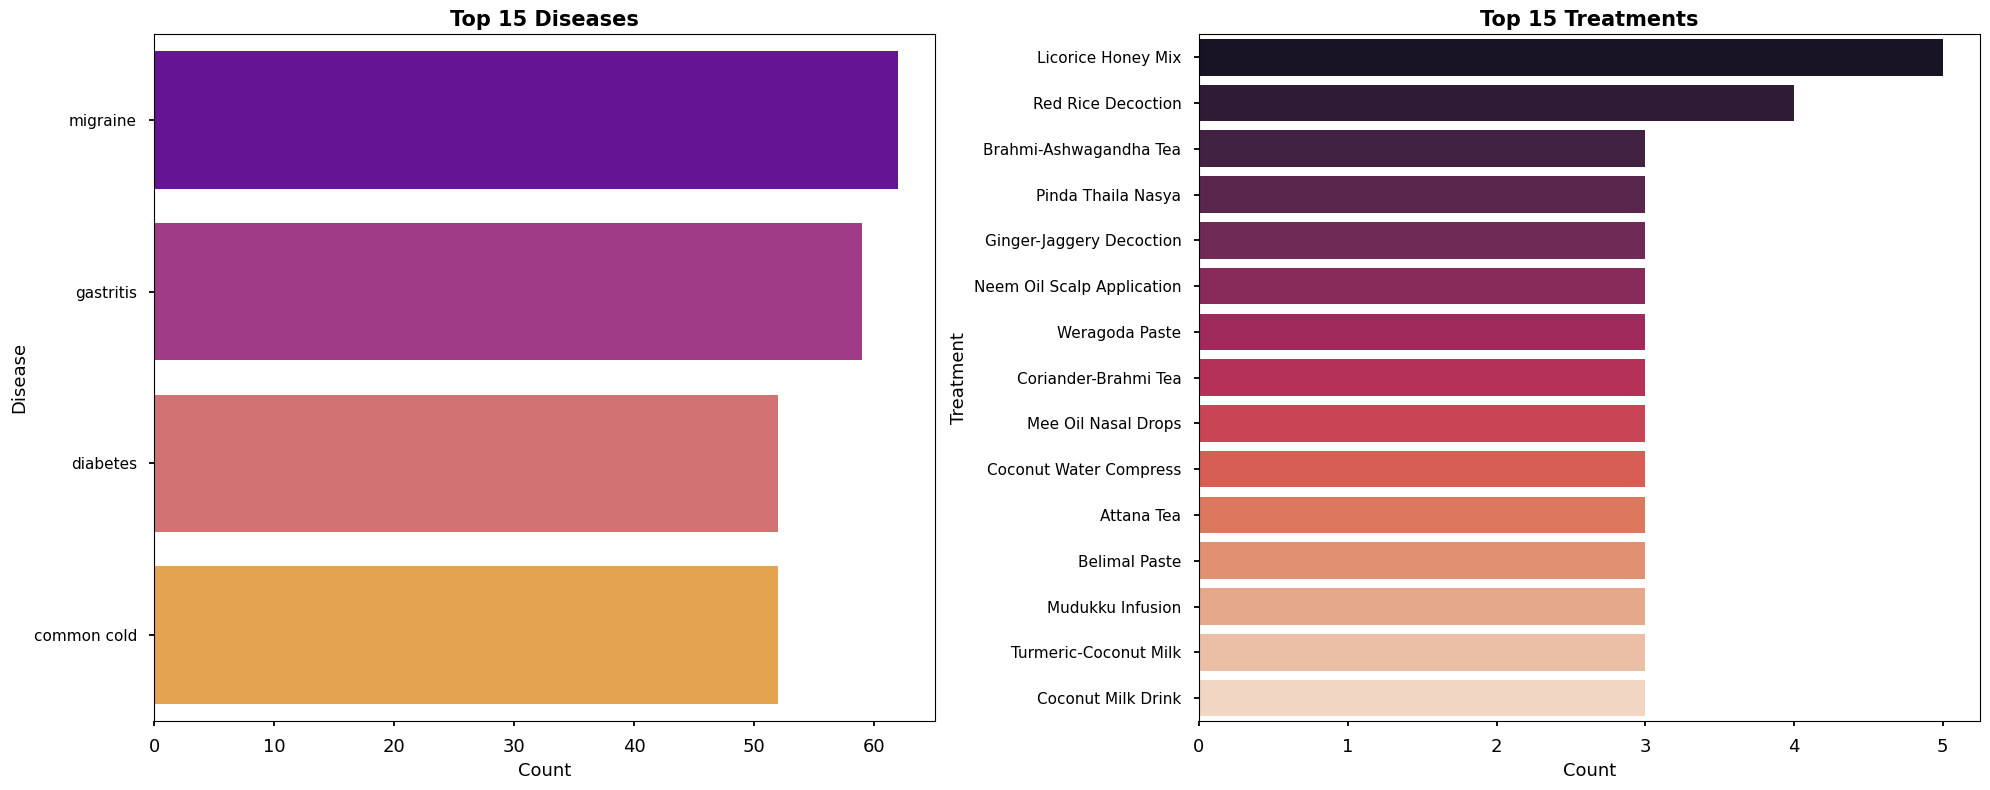

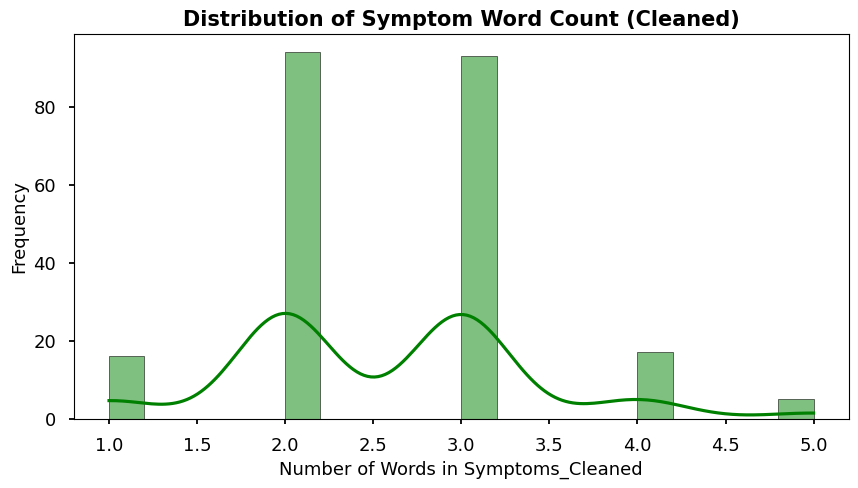


Symptom Word Count Stats:
count    225.00
mean       2.56
std        0.82
min        1.00
25%        2.00
50%        3.00
75%        3.00
max        5.00
Name: Symptoms_Word_Count, dtype: float64

Generating Symptom Word Cloud...


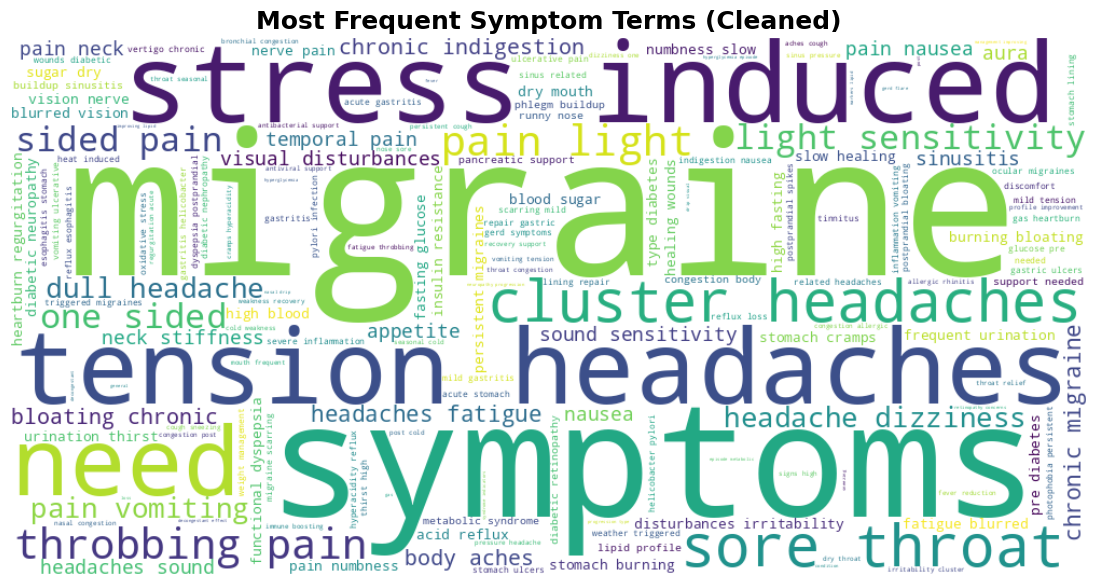


--- 3.3 Feature vs. Target Relationships ---


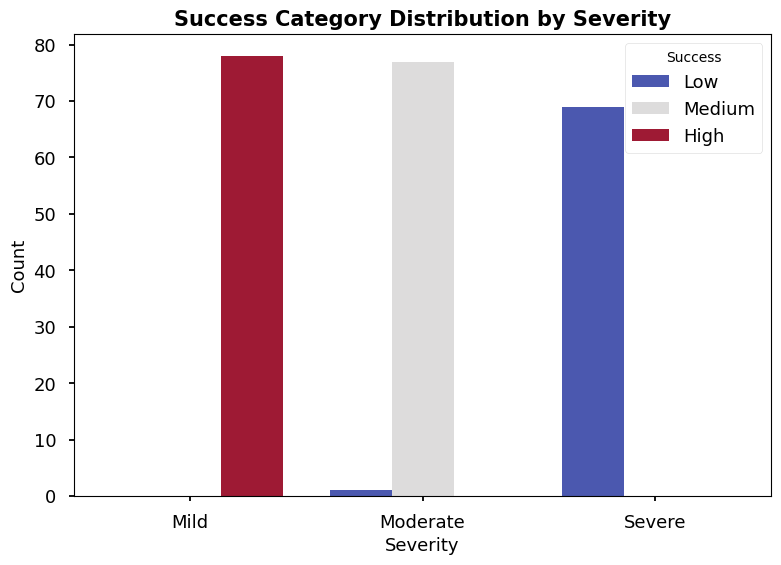

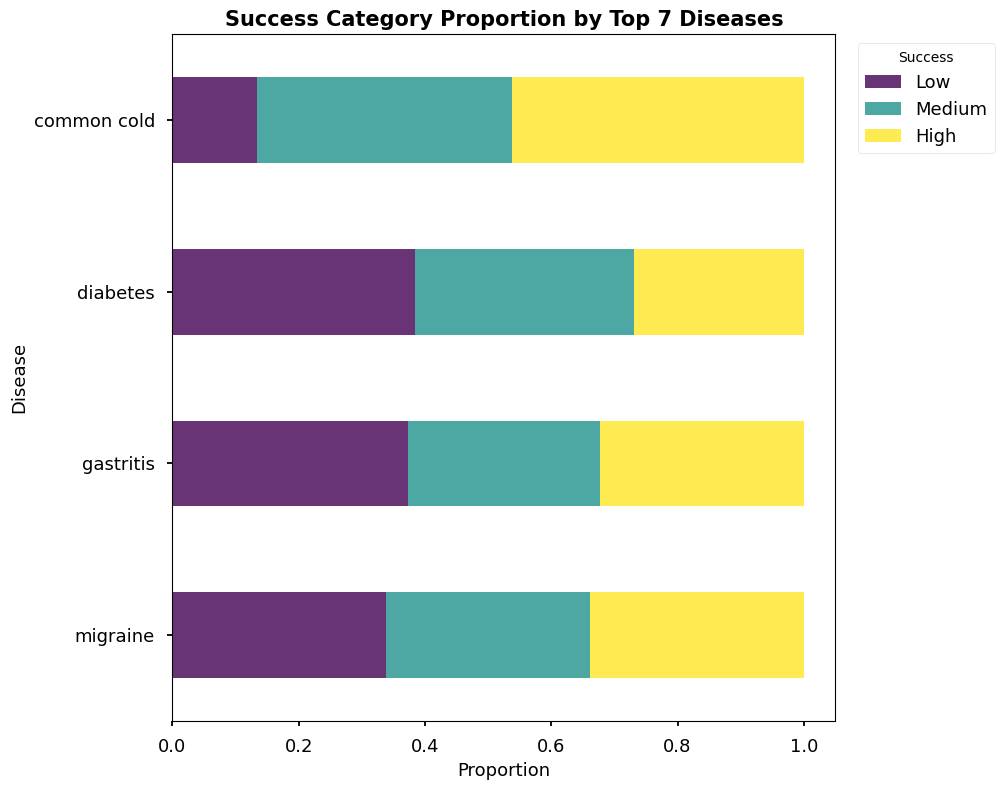

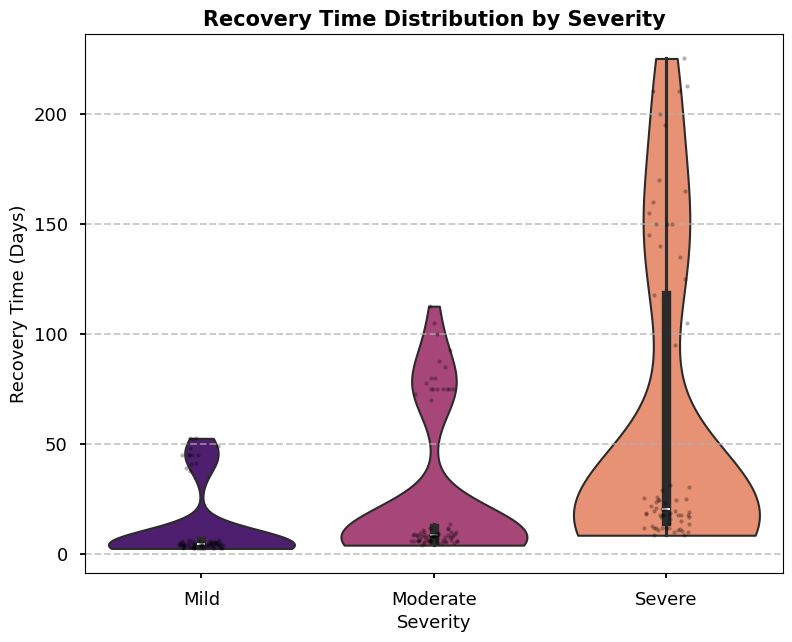

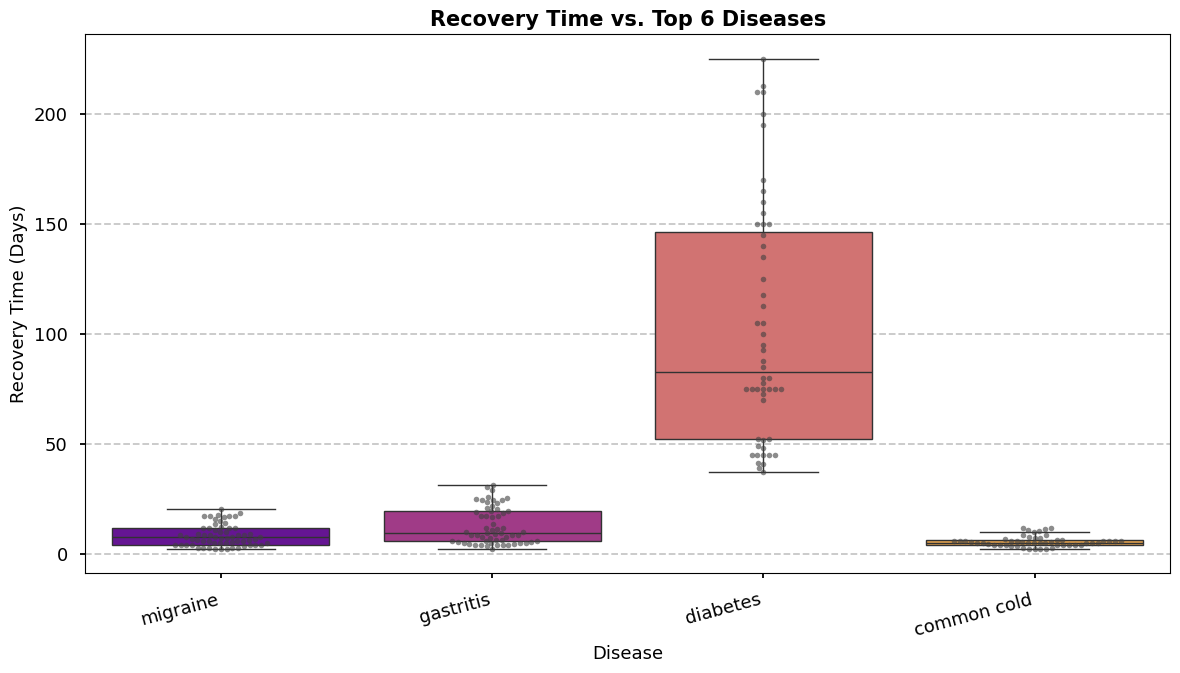

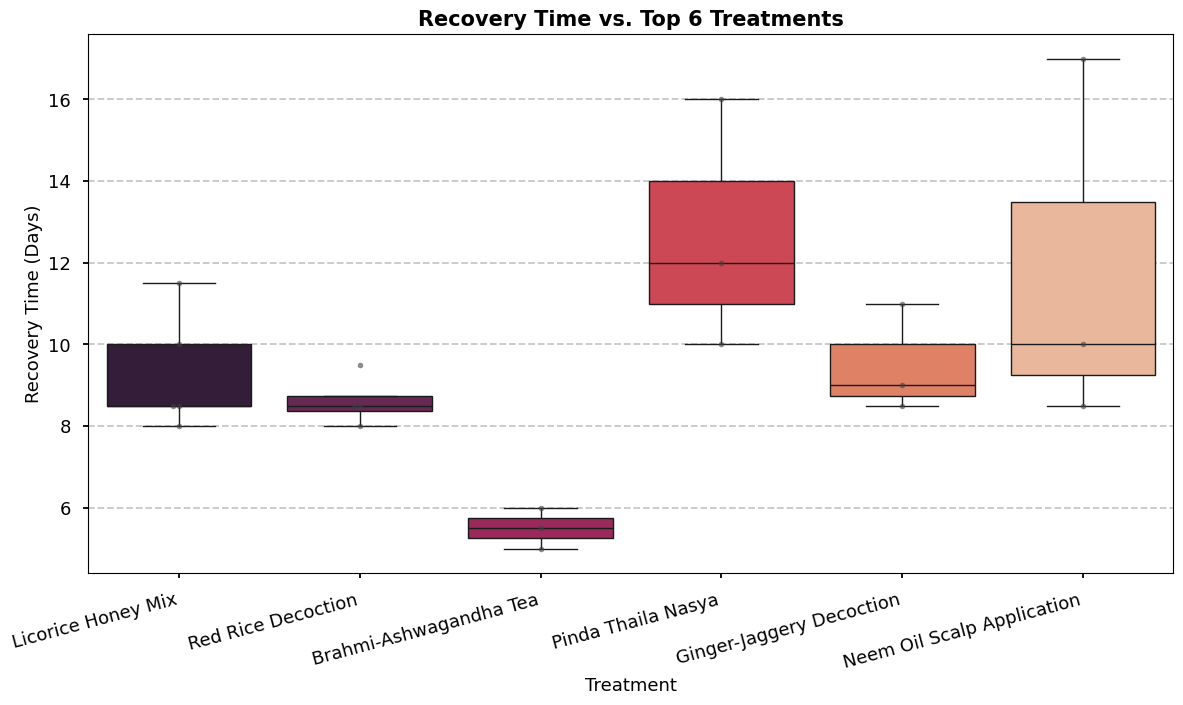

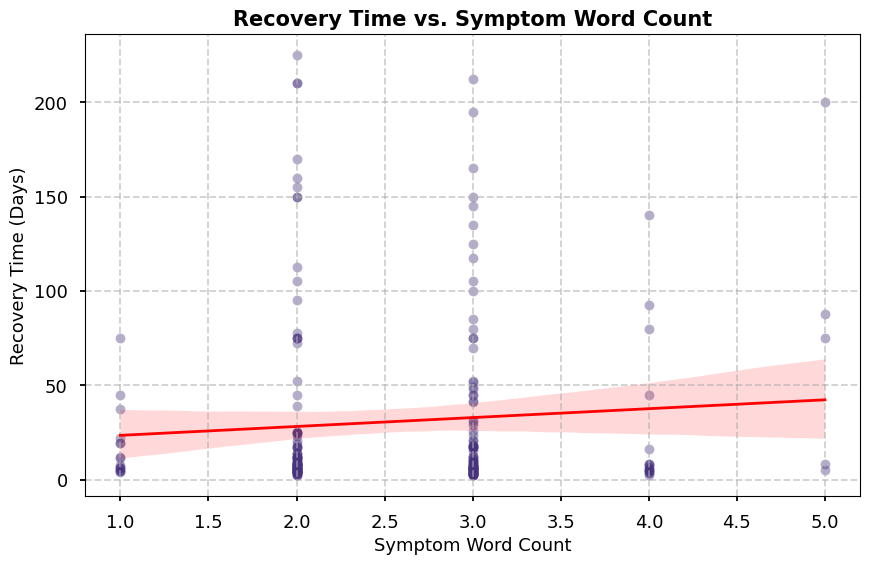


Correlation between Recovery Time and Symptom Word Count: 0.081
  (A correlation close to 0 suggests weak linear relationship)

--- 3.4 Initial Correlation Check ---
Calculating correlation matrix for EDA features...


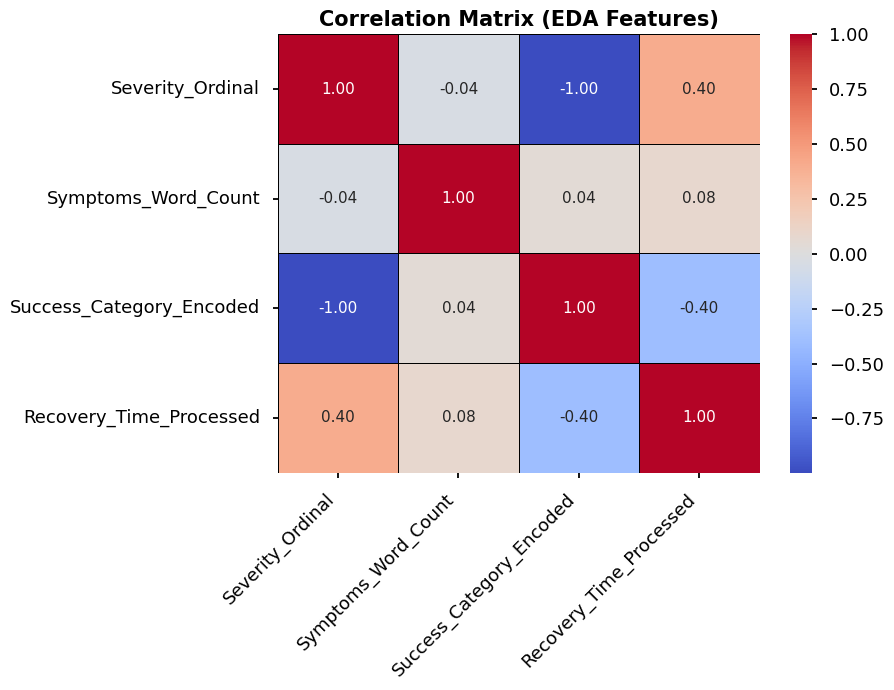

In [3]:

# --- 3. Enhanced Exploratory Data Analysis (EDA) ---
print(f"\n{COLOR['BOLD']}{COLOR['HEADER']}--- (3) Enhanced Exploratory Data Analysis ---{COLOR['END']}")

# === 3.1 Target Variable Analysis ===
print(f"\n{COLOR['BLUE']}--- 3.1 Target Variable Analysis ---{COLOR['END']}")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Success Category Distribution (Code remains the same)
sns.countplot(x=df['Success_Category_Encoded'].map(reverse_success_map), ax=axes[0], palette='viridis', order=['Low', 'Medium', 'High'])
axes[0].set_title('Distribution of Success Category', fontsize=15, fontweight='bold')
axes[0].set_xlabel('Success Category', fontsize=13); axes[0].set_ylabel('Count', fontsize=13)
for p in axes[0].patches: # Add count labels
    axes[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=11)

# --- Recovery Time Distribution (Corrected) ---
sns.histplot(df['Recovery_Time_Processed'].dropna(), kde=True, ax=axes[1], color='teal', bins=20, line_kws={'linewidth': 2.5})
mean_rec_time = df['Recovery_Time_Processed'].mean()
median_rec_time = df['Recovery_Time_Processed'].median()

# Use standard color names recognized by matplotlib for plotting
axes[1].axvline(mean_rec_time, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_rec_time:.1f} days')
axes[1].axvline(median_rec_time, color='orange', linestyle='-', linewidth=2, label=f'Median: {median_rec_time:.1f} days')
# --- End Correction ---

axes[1].set_title('Distribution of Processed Recovery Time', fontsize=15, fontweight='bold')
axes[1].set_xlabel('Recovery Time (Days)', fontsize=13); axes[1].set_ylabel('Frequency', fontsize=13)
axes[1].legend()
plt.tight_layout(); plt.show()

# === 3.2 Feature Distributions ===
print(f"\n{COLOR['BLUE']}--- 3.2 Feature Distributions ---{COLOR['END']}")
# Severity Distribution
plt.figure(figsize=(8, 5))
ax_sev = sns.countplot(x='Severity', data=df, palette='magma', order=severity_categories)
plt.title('Severity Distribution', fontsize=15, fontweight='bold')
plt.xlabel('Severity', fontsize=13); plt.ylabel('Count', fontsize=13)
for p in ax_sev.patches: ax_sev.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=11)
plt.show()

# Top Diseases and Treatments Bar Plots
fig, axes = plt.subplots(1, 2, figsize=(20, 8)) # Wider figure
top_n = 15 # Show top 15 for better visibility
# Diseases
disease_counts = df['Disease_Cleaned'].value_counts().nlargest(top_n)
sns.barplot(x=disease_counts.values, y=disease_counts.index, ax=axes[0], palette='plasma', hue=disease_counts.index, legend=False, dodge=False)
axes[0].set_title(f'Top {top_n} Diseases', fontsize=15, fontweight='bold'); axes[0].set_xlabel('Count', fontsize=13); axes[0].set_ylabel('Disease', fontsize=13)
axes[0].tick_params(axis='y', labelsize=11) # Adjust y-tick label size
# Treatments
treatment_counts = df['Treatment_Cleaned'].value_counts().nlargest(top_n)
sns.barplot(x=treatment_counts.values, y=treatment_counts.index, ax=axes[1], palette='rocket', hue=treatment_counts.index, legend=False, dodge=False)
axes[1].set_title(f'Top {top_n} Treatments', fontsize=15, fontweight='bold'); axes[1].set_xlabel('Count', fontsize=13); axes[1].set_ylabel('Treatment', fontsize=13)
axes[1].tick_params(axis='y', labelsize=11) # Adjust y-tick label size
plt.tight_layout(); plt.show()

# Symptom Word Count Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['Symptoms_Word_Count'], bins=20, kde=True, color='green')
plt.title('Distribution of Symptom Word Count (Cleaned)', fontsize=15, fontweight='bold')
plt.xlabel('Number of Words in Symptoms_Cleaned', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.show()
print("\nSymptom Word Count Stats:")
print(df['Symptoms_Word_Count'].describe().round(2))

# Symptom Word Cloud
if WordCloud:
    try:
        print("\nGenerating Symptom Word Cloud...")
        # Concatenate all cleaned symptom strings
        long_string = ' '.join(df['Symptoms_Cleaned'].dropna().astype(str))
        if long_string:
            # Create WordCloud object with specified parameters
            wordcloud = WordCloud(width=1000, height=500, background_color="white", colormap='viridis',
                                  max_words=200, contour_color='steelblue', contour_width=1,
                                  prefer_horizontal=0.9, # Prefer horizontal words
                                  collocation_threshold=10 # Reduce common word pairs slightly
                                 ).generate(long_string)
            # Display the generated Word Cloud
            plt.figure(figsize=(14, 7))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off") # Hide axes
            plt.title('Most Frequent Symptom Terms (Cleaned)', fontsize=18, fontweight='bold')
            plt.show()
        else:
            print("  No symptom text available to generate word cloud.")
    except ImportError: # Already handled at the top, but good practice
        print(f"{COLOR['YELLOW']}WordCloud library not found. Cannot generate word cloud.{COLOR['END']}")
    except Exception as e:
        print(f"{COLOR['RED']}Error generating word cloud: {e}{COLOR['END']}")
else: # If WordCloud was None from the start
    print(f"{COLOR['YELLOW']}Skipping word cloud plot (wordcloud library not installed).{COLOR['END']}")


# === 3.3 Feature vs. Target Relationships ===
print(f"\n{COLOR['BLUE']}--- 3.3 Feature vs. Target Relationships ---{COLOR['END']}")

# --- Success Category vs Features ---
# vs Severity (Count Plot)
plt.figure(figsize=(9, 6))
sns.countplot(data=df, x='Severity', hue='Success_Category_Encoded', palette='coolwarm', order=severity_categories)
plt.title('Success Category Distribution by Severity', fontsize=15, fontweight='bold')
plt.xlabel('Severity', fontsize=13); plt.ylabel('Count', fontsize=13)
plt.legend(title='Success', labels=['Low', 'Medium', 'High'], loc='upper right')
plt.show()

# vs Top N Diseases (Proportion Plot - More Insightful for Comparison)
top_n_disease_success = 7
top_diseases_list = df['Disease_Cleaned'].value_counts().nlargest(top_n_disease_success).index
df_top_disease = df[df['Disease_Cleaned'].isin(top_diseases_list)].copy()
# Calculate proportions
prop_df = df_top_disease.groupby(['Disease_Cleaned', 'Success_Category_Encoded']).size().unstack(fill_value=0)
prop_df = prop_df.apply(lambda x: x / x.sum(), axis=1) # Normalize row-wise
prop_df.rename(columns=reverse_success_map, inplace=True) # Rename columns for legend

prop_df.loc[top_diseases_list].plot(kind='barh', stacked=True, figsize=(12, 8), colormap='viridis', alpha=0.8)
plt.title(f'Success Category Proportion by Top {top_n_disease_success} Diseases', fontsize=15, fontweight='bold')
plt.xlabel('Proportion', fontsize=13); plt.ylabel('Disease', fontsize=13)
plt.legend(title='Success', bbox_to_anchor=(1.02, 1), loc='upper left') # Move legend outside
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
plt.show()

# --- Recovery Time vs Features ---
# vs Severity (Violin Plot - Enhanced)
plt.figure(figsize=(9, 7))
sns.violinplot(x='Severity', y='Recovery_Time_Processed', data=df, palette='magma', order=severity_categories, inner='box', cut=0, linewidth=1.5) # Show box inside
sns.stripplot(x='Severity', y='Recovery_Time_Processed', data=df, order=severity_categories, color='black', alpha=0.3, size=3) # Overlay points
plt.title('Recovery Time Distribution by Severity', fontsize=15, fontweight='bold')
plt.xlabel('Severity', fontsize=13); plt.ylabel('Recovery Time (Days)', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add horizontal grid
plt.show()

# vs Top N Diseases (Box Plot - Enhanced)
plt.figure(figsize=(14, 7))
top_n_disease_recovery = 6
top_diseases_rec_list = df['Disease_Cleaned'].value_counts().nlargest(top_n_disease_recovery).index
sns.boxplot(x='Disease_Cleaned', y='Recovery_Time_Processed', data=df[df['Disease_Cleaned'].isin(top_diseases_rec_list)], palette='plasma', order=top_diseases_rec_list, showfliers=False) # Hide outliers for cleaner look
sns.swarmplot(x='Disease_Cleaned', y='Recovery_Time_Processed', data=df[df['Disease_Cleaned'].isin(top_diseases_rec_list)], order=top_diseases_rec_list, color=".25", size=4, alpha=0.6) # Overlay points
plt.title(f'Recovery Time vs. Top {top_n_disease_recovery} Diseases', fontsize=15, fontweight='bold')
plt.xlabel('Disease', fontsize=13); plt.ylabel('Recovery Time (Days)', fontsize=13)
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# vs Top N Treatments (Box Plot - Enhanced)
plt.figure(figsize=(14, 7))
top_n_treatment_recovery = 6
top_treatments_rec_list = df['Treatment_Cleaned'].value_counts().nlargest(top_n_treatment_recovery).index
sns.boxplot(x='Treatment_Cleaned', y='Recovery_Time_Processed', data=df[df['Treatment_Cleaned'].isin(top_treatments_rec_list)], palette='rocket', order=top_treatments_rec_list, showfliers=False)
sns.swarmplot(x='Treatment_Cleaned', y='Recovery_Time_Processed', data=df[df['Treatment_Cleaned'].isin(top_treatments_rec_list)], order=top_treatments_rec_list, color=".25", size=4, alpha=0.6)
plt.title(f'Recovery Time vs. Top {top_n_treatment_recovery} Treatments', fontsize=15, fontweight='bold')
plt.xlabel('Treatment', fontsize=13); plt.ylabel('Recovery Time (Days)', fontsize=13)
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# vs Symptom Word Count (Scatter/Regplot)
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='Symptoms_Word_Count', y='Recovery_Time_Processed',
            scatter_kws={'alpha':0.4, 's': 50}, # Adjust scatter points
            line_kws={'color':'red', 'linewidth': 2}) # Style regression line
plt.title('Recovery Time vs. Symptom Word Count', fontsize=15, fontweight='bold')
plt.xlabel('Symptom Word Count', fontsize=13)
plt.ylabel('Recovery Time (Days)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
corr_symptom_recovery = df['Recovery_Time_Processed'].corr(df['Symptoms_Word_Count']).round(3)
print(f"\nCorrelation between Recovery Time and Symptom Word Count: {corr_symptom_recovery}")
print("  (A correlation close to 0 suggests weak linear relationship)")


# === 3.4 Initial Correlation Check (Robust) ===
print(f"\n{COLOR['BLUE']}--- 3.4 Initial Correlation Check ---{COLOR['END']}")
# Ensure Severity_Ordinal Exists using the map
if 'Severity_Ordinal' not in df.columns:
    if 'severity_map' not in locals(): severity_map = {'Mild': 0, 'Moderate': 1, 'Severe': 2}
    df['Severity_Ordinal'] = df['Severity'].map(severity_map)
    if df['Severity_Ordinal'].isna().any():
        median_sev = df['Severity_Ordinal'].median(); df['Severity_Ordinal'].fillna(median_sev, inplace=True)

# Define columns for correlation
numeric_eda_cols = ['Severity_Ordinal', 'Symptoms_Word_Count', 'Success_Category_Encoded', 'Recovery_Time_Processed']
missing_cols = [col for col in numeric_eda_cols if col not in df.columns]
if missing_cols: print(f"{COLOR['RED']}Error: Columns missing for correlation heatmap: {missing_cols}{COLOR['END']}")
else:
    print("Calculating correlation matrix for EDA features...")
    correlation_matrix_eda = df[numeric_eda_cols].corr()
    plt.figure(figsize=(9, 7))
    sns.heatmap(correlation_matrix_eda, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, linecolor='black', annot_kws={"size": 11}) # Larger annotations
    plt.title('Correlation Matrix (EDA Features)', fontsize=15, fontweight='bold')
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
    plt.tight_layout(); plt.show()

print("="*95)



### 4. Define Features (X) and Targets (y) for Modeling
In this section, we define the features (`X`) and targets (`y`) for both classification and regression tasks.

- **Targets (`y_clf` and `y_reg`)**:
    - `y_clf`: The target variable for classification, which is `Success_Category_Encoded`. This represents the success category of a treatment (Low, Medium, High).
    - `y_reg`: The target variable for regression, which is `Recovery_Time_Processed`. This represents the recovery time in days for a patient after treatment.
    
- **Features (`X_clf` and `X_reg`)**:
    - `X_clf`: The features for the classification task. It includes `Severity`, `Disease_Cleaned`, `Treatment_Cleaned`, `Symptoms_Cleaned`, and `Recovery_Time_Processed`. The column `Recovery_Time_Processed` is renamed to `Recovery_Time_Feat` for clarity.
    - `X_reg`: The features for the regression task. It includes `Severity`, `Disease_Cleaned`, `Treatment_Cleaned`, and `Symptoms_Cleaned`.

The shape of the feature matrices `X_clf` and `X_reg` is printed to confirm the dimensions.

---

### 5. Train/Test Split
Here, we split the data into training and testing sets for both classification and regression tasks.

- **Classification Split**:
    - `X_train_clf`, `X_test_clf`: The features for classification in the training and testing sets.
    - `y_train_clf`, `y_test_clf`: The target variable for classification in the training and testing sets.
    - The data is split with a `test_size` of 30% and the `random_state` is set to ensure reproducibility. Stratification ensures that the class distribution is preserved in both training and testing sets.
    
- **Regression Split**:
    - `X_train_reg`, `X_test_reg`: The features for regression in the training and testing sets.
    - `y_train_reg`, `y_test_reg`: The target variable for regression in the training and testing sets.
    - We also ensure that missing values in `y_reg` are handled by excluding them from the training and testing sets.
    
The shapes of the resulting `X_train` and `X_test` for both classification and regression are printed to confirm the split.


In [7]:

# --- 4. Define Features (X) and Targets (y) for Modeling ---
print(f"\n{COLOR['BOLD']}{COLOR['HEADER']}--- (4) Defining Features and Targets ---{COLOR['END']}")
y_clf = df['Success_Category_Encoded'].copy(); y_reg = df['Recovery_Time_Processed'].copy()
# Use ORIGINAL column names expected by the ColumnTransformer input
X_clf = df[['Severity', 'Disease_Cleaned', 'Treatment_Cleaned', 'Symptoms_Cleaned', 'Recovery_Time_Processed']].copy()
X_clf.rename(columns={'Recovery_Time_Processed': 'Recovery_Time_Feat'}, inplace=True)
X_reg = df[['Severity', 'Disease_Cleaned', 'Treatment_Cleaned', 'Symptoms_Cleaned']].copy()
print(f"Shape of X_clf (Input): {X_clf.shape}"); print(f"Shape of X_reg (Input): {X_reg.shape}")

# --- 5. Train/Test Split ---
print(f"\n{COLOR['BOLD']}{COLOR['HEADER']}--- (5) Train/Test Split ---{COLOR['END']}")
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.30, random_state=SEED, stratify=y_clf)
train_indices = X_train_clf.index; test_indices = X_test_clf.index
X_train_reg = X_reg.loc[train_indices]; X_test_reg = X_reg.loc[test_indices]
y_train_reg = y_reg.loc[train_indices]; y_test_reg = y_reg.loc[test_indices]
train_reg_valid_idx = y_train_reg.dropna().index; test_reg_valid_idx = y_test_reg.dropna().index
X_train_reg = X_train_reg.loc[train_reg_valid_idx]; y_train_reg = y_train_reg.loc[train_reg_valid_idx]
X_test_reg = X_test_reg.loc[test_reg_valid_idx]; y_test_reg = y_test_reg.loc[test_reg_valid_idx]
print(f"Classification shapes: X_train={X_train_clf.shape}, X_test={X_test_clf.shape}")
print(f"Regression shapes: X_train={X_train_reg.shape}, X_test={X_test_reg.shape}")


--- (4) Defining Features and Targets ---
Shape of X_clf (Input): (225, 5)
Shape of X_reg (Input): (225, 4)

--- (5) Train/Test Split ---
Classification shapes: X_train=(157, 5), X_test=(68, 5)
Regression shapes: X_train=(157, 4), X_test=(68, 4)


### 6. Preprocessing Pipeline Construction
This section defines the preprocessing pipeline for both classification and regression tasks. Each pipeline applies specific transformations to handle different feature types (text, categorical, ordinal, and numeric features).

#### Text Features:
- **Text Feature (`Symptoms_Cleaned`)**: The text data is transformed using `TfidfVectorizer` to convert text into numerical features. It considers n-grams (1-2 words), uses sublinear term frequency, and drops words that appear in fewer than 3 documents (`min_df=3`).

#### Categorical Features:
- **One-Hot Encoded Features** (`Disease_Cleaned`, `Treatment_Cleaned`): These categorical features are handled by `OneHotEncoder` after imputing missing values with a constant value (`_missing_`).
- **Ordinal Feature** (`Severity`): Ordinal encoding is applied after imputing missing values with the most frequent category. The encoder uses predefined categories from the variable `severity_categories` and handles unknown categories with a special value (-1).

#### Numeric Features:
- **Numeric Features for Classification** (`Recovery_Time_Feat`): The numeric features are processed by imputing missing values with the median and scaling using `StandardScaler`.

#### ColumnTransformer:
- **Classification Preprocessor (`preprocessor_clf`)**: This transformer applies the appropriate transformation to each feature type (text, categorical, ordinal, and numeric features).
- **Regression Preprocessor (`preprocessor_reg`)**: Similar to the classification preprocessor, but excludes numeric features used for classification tasks.

### Building Full Pipelines
Here, we create complete machine learning pipelines for both classification and regression tasks.

- **Classifiers**: The following classification models are imported:
  - Logistic Regression
  - Linear SVM
  - SVM with RBF kernel
  - Random Forest Classifier
  - Gradient Boosting Classifier
  - XGBoost Classifier
  - LightGBM Classifier
  - HistGradientBoosting Classifier
  - K-Nearest Neighbors Classifier
  
- **Regressors**: The following regression models are imported:
  - Ridge Regression
  - Lasso Regression
  - ElasticNet Regression
  - Huber Regressor
  - Random Forest Regressor
  - Gradient Boosting Regressor
  - XGBoost Regressor
  - LightGBM Regressor
  - HistGradientBoosting Regressor
  - K-Nearest Neighbors Regressor

#### Pipeline Creation:
- **Classification Pipelines** (`clf_pipelines`): Each classification model is paired with the corresponding preprocessing pipeline (`preprocessor_clf`).
- **Regression Pipelines** (`reg_pipelines`): Similarly, each regression model is paired with the corresponding preprocessing pipeline (`preprocessor_reg`).

Finally, the code prints the number of created pipelines for both classification and regression.

---
### Key Points:
1. **Feature Transformation**: Different preprocessing techniques are applied to various feature types: text, categorical, ordinal, and numeric.
2. **Pipeline Construction**: Full pipelines are constructed for both classification and regression tasks, incorporating both preprocessing and modeling steps.
3. **Model Setup**: Multiple machine learning models are prepared for classification and regression, each in its own pipeline.


In [8]:

# --- 6. Preprocessing Pipeline Construction ---
print(f"\n{COLOR['BOLD']}{COLOR['HEADER']}--- (6) Preprocessing Pipeline Construction ---{COLOR['END']}")
text_feature = 'Symptoms_Cleaned'; ohe_features = ['Disease_Cleaned', 'Treatment_Cleaned']; ordinal_features = ['Severity']; numeric_features_clf = ['Recovery_Time_Feat']
print("Defining Transformers..."); text_transformer = TfidfVectorizer(max_features=700, ngram_range=(1, 2), stop_words='english', sublinear_tf=True, min_df=3); print(f"  TF-IDF: max_features=700, ngram=(1,2), min_df=3")
ohe_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='_missing_')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
ordinal_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ordinal', OrdinalEncoder(categories=[severity_categories], handle_unknown='use_encoded_value', unknown_value=-1))])
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
preprocessor_reg = ColumnTransformer(transformers=[('text', text_transformer, text_feature), ('ohe_cats', ohe_transformer, ohe_features), ('ord_cats', ordinal_transformer, ordinal_features)], remainder='drop', sparse_threshold=0, verbose_feature_names_out=False)
preprocessor_clf = ColumnTransformer(transformers=[('text', text_transformer, text_feature), ('ohe_cats', ohe_transformer, ohe_features), ('ord_cats', ordinal_transformer, ordinal_features), ('num', numeric_transformer, numeric_features_clf)], remainder='drop', sparse_threshold=0, verbose_feature_names_out=False)

# --- Build Full Pipelines ---
print("\n--- Building Full Model Pipelines ---")
# ** Ensure ALL imported models are included here **
classifiers = { "Logistic Regression": LogisticRegression(max_iter=3000, random_state=SEED, solver='liblinear', class_weight='balanced'), "Linear SVM": LinearSVC(random_state=SEED, class_weight='balanced', dual=False, max_iter=3000), "SVM (RBF)": SVC(kernel='rbf', probability=True, random_state=SEED, class_weight='balanced'), "Random Forest": RandomForestClassifier(random_state=SEED, class_weight='balanced_subsample', n_jobs=-1, n_estimators=150), "Gradient Boosting": GradientBoostingClassifier(random_state=SEED, n_estimators=150), "XGBoost": xgb.XGBClassifier(random_state=SEED, use_label_encoder=False, eval_metric='mlogloss'), "LightGBM": LGBMClassifier(random_state=SEED, class_weight='balanced', verbosity=-1, n_jobs=-1), "HistGradientBoosting": HistGradientBoostingClassifier(random_state=SEED, class_weight='balanced'), "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1) }
regressors = { "Ridge": Ridge(random_state=SEED), "Lasso": Lasso(random_state=SEED, max_iter=4000), "ElasticNet": ElasticNet(random_state=SEED, max_iter=4000), "HuberRegressor": HuberRegressor(max_iter=1000), "Random Forest": RandomForestRegressor(random_state=SEED, n_jobs=-1, n_estimators=150), "Gradient Boosting": GradientBoostingRegressor(random_state=SEED, n_estimators=150), "XGBoost": xgb_reg.XGBRegressor(random_state=SEED, objective='reg:squarederror', n_jobs=-1), "LightGBM": LGBMRegressor(random_state=SEED, verbosity=-1, n_jobs=-1), "HistGradientBoosting": HistGradientBoostingRegressor(random_state=SEED), "KNN": KNeighborsRegressor(n_neighbors=5, n_jobs=-1) }

clf_pipelines = {name: Pipeline([('preprocessor', preprocessor_clf), ('classifier', model)]) for name, model in classifiers.items()}
reg_pipelines = {name: Pipeline([('preprocessor', preprocessor_reg), ('regressor', model)]) for name, model in regressors.items()}
print(f"Created {len(clf_pipelines)} classification and {len(reg_pipelines)} regression pipelines.")


--- (6) Preprocessing Pipeline Construction ---
Defining Transformers...
  TF-IDF: max_features=700, ngram=(1,2), min_df=3

--- Building Full Model Pipelines ---
Created 9 classification and 10 regression pipelines.


# **Model Training, Evaluation & Overfitting Check**

This section explains how to train machine learning models, evaluate their performance, check for overfitting or underfitting, and perform cross-validation to ensure the models generalize well. It also covers how to analyze potential issues such as instability in the model's performance.

## 1. **Preprocessing Pipeline**

Before training a model, it is crucial to preprocess the data. Preprocessing includes transforming and cleaning the data to make it suitable for machine learning algorithms.

- **Text Features**:
  - **TF-IDF Vectorization**: Converts text into numerical features that machine learning models can understand. It measures the importance of each word in a document by considering how often it appears in the document relative to its frequency in the entire dataset.
  
- **Categorical Features**:
  - **One-hot Encoding**: Converts categorical variables (like "color" or "city") into a binary format. Each category is represented by a binary column, with a `1` indicating the presence of the category and a `0` indicating its absence.
  - **Ordinal Encoding**: Converts categorical variables with a natural order (like "low", "medium", "high") into numeric values that represent the rank or order.

- **Numeric Features**:
  - **Median Imputation**: Fills missing values in numerical features using the median (middle value) of the column. This ensures that no data is lost due to missing values.
  - **Standard Scaling**: Normalizes numeric features so that they have a mean of 0 and a standard deviation of 1. This helps prevent features with larger scales from dominating the model training.

## 2. **Classifier & Regressor Pipelines**

- **Classifiers**: These models are used for classification tasks where the goal is to predict a category (e.g., "Spam" or "Not Spam").
  - **Common Classifiers**: Logistic Regression, Random Forest, XGBoost, etc.
  
- **Regressors**: These models are used for regression tasks where the goal is to predict a continuous value (e.g., predicting house prices).
  - **Common Regressors**: Ridge Regression, Random Forest, etc.

Each model is wrapped in a **pipeline**, which ensures that preprocessing steps are applied before the model is trained. Pipelines help automate the process and ensure consistency.

## 3. **Model Evaluation**

Once models are trained, it's essential to evaluate how well they perform. We evaluate models using a variety of metrics, and this section discusses how to interpret them.

### **For Classifiers:**

- **Metrics for Classification Models**:
  - **Balanced Accuracy**: Measures the accuracy of the model, but with a focus on balancing the accuracy across different classes (important for imbalanced datasets).
  - **F1 Score (weighted)**: A combination of precision and recall, giving us a balance between the two metrics. It is useful when we want to balance the trade-off between false positives and false negatives.
  - **Precision (weighted)**: Measures how many of the predicted positives are actually positive.
  - **Recall (weighted)**: Measures how many of the actual positives were correctly identified by the model.
  - **Log Loss**: Measures the accuracy of probabilistic predictions, where lower values are better.
  - **ROC AUC**: A metric that evaluates the model’s ability to distinguish between classes, especially in multi-class classification problems.

- **Cross-validation**: To ensure the model generalizes well to unseen data, we use **Stratified K-fold cross-validation**. This technique divides the data into K parts, trains the model on K-1 parts, and tests it on the remaining part. The process is repeated K times to get an average performance score.

- **Overfitting/Underfitting/Instability Checks**:
  - **Overfitting**: Occurs when a model performs well on the training data but poorly on the test data. This happens when the model learns noise or irrelevant patterns from the training data.
  - **Instability**: This happens when a model’s performance varies significantly across different cross-validation folds, indicating that the model might not be stable.
  - **Underfitting**: Occurs when the model performs poorly on both training and test data, indicating that the model is too simple to capture the underlying patterns in the data.

### **For Regressors:**

- **Metrics for Regression Models**:
  - **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values. Lower values indicate better model performance.
  - **MAE (Mean Absolute Error)**: Measures the average absolute difference between predicted and actual values. Like RMSE, lower values are better.
  - **MedAE (Median Absolute Error)**: Measures the median of the absolute errors, providing robustness against outliers.
  - **R² (Coefficient of Determination)**: Measures how well the model explains the variance in the data. A higher R² means the model fits the data better.

- **Cross-validation**: We use **K-fold cross-validation** to evaluate the performance of regression models. This technique helps ensure that the model does not overfit or underfit and generalizes well to unseen data.

- **Overfitting/Underfitting/Instability Checks**:
  - **Overfitting**: Identified when a model performs significantly better on training data than on test data.
  - **Instability**: Identified when the model’s performance fluctuates a lot across different folds of cross-validation.
  - **Underfitting**: Identified when the model performs poorly on both training and test data.

## 4. **Model Performance Summary**

After evaluation, the results of each model are compiled into tables for easier comparison.

### **Classifier Performance Summary**:
The classifiers are sorted by **CV Balanced Accuracy**, and the table displays:
- **Train and Test Balanced Accuracy**: How well the model performs on training and test data.
- **F1 Score (weighted)**: A balanced score that considers both precision and recall.
- **Log Loss**: A measure of how well the classifier predicts probabilities.
- **Cross-validation Scores**: The average balanced accuracy and F1 score across the cross-validation folds.

### **Regressor Performance Summary**:
The regressors are sorted by **CV RMSE**, and the table displays:
- **Train and Test RMSE**: How well the model performs on training and test data.
- **MAE and MedAE**: Alternative error measures to RMSE.
- **R² Score**: A measure of how well the model fits the data.
- **Cross-validation Scores**: The average RMSE and R² across the cross-validation folds.

## 5. **Analysis of Results**

Once the results are summarized, we perform a qualitative analysis to interpret the performance of the models:

- **Good Fit & Generalization**: If the model performs well on both training and test data with stable cross-validation scores, it is considered to generalize well.
  
- **Moderate Fit**: If the model performs well but might need further tuning or optimization, it is flagged as having a moderate fit.
  
- **Potential Overfitting**: If a model performs very well on the training data but poorly on the test data, it is flagged for potential overfitting.
  
- **Potential Instability**: If the performance across cross-validation folds is highly variable, the model might be unstable.
  
- **Potential Underfitting**: If the model performs poorly on both training and test data, it is flagged for underfitting, indicating it might be too simple or need more complex features.

---

### **Example Evaluation Results**

Here are example summary tables for both classifiers and regressors:

### **Classifier Performance Summary (Sorted by CV Balanced Accuracy)**:
| Model                | Train Bal Acc | Test Bal Acc | Train F1(W) | Test F1(W) | Test LogLoss | CV Bal Acc | CV F1(W) | Avg Fit Time(s) |
|----------------------|---------------|--------------|-------------|------------|--------------|------------|----------|-----------------|
| **Model 1**           | 0.85          | 0.80         | 0.83        | 0.80       | 0.20         | 0.82       | 0.81     | 2.5             |
| **Model 2**           | 0.87          | 0.79         | 0.85        | 0.78       | 0.18         | 0.80       | 0.78     | 3.1             |
| *Higher CV Bal Acc / F1(W) are better. Avoid perfect CV scores (1.0000) if good non-perfect alternatives exist.*

### **Regressor Performance Summary (Sorted by CV RMSE)**:
| Model                | Train RMSE | Test RMSE | Train MAE | Test MAE | Train R² | Test R² | CV RMSE | CV R² | Avg Fit Time(s) |
|----------------------|------------|-----------|-----------|----------|----------|---------|---------|-------|-----------------|
| **Model 1**           | 0.30       | 0.32      | 0.25      | 0.28     | 0.80     | 0.75    | 0.31    | 0.77  | 4.2             |
| **Model 2**           | 0.28       | 0.34      | 0.22      | 0.26     | 0.83     | 0.70    | 0.33    | 0.75  | 4.8             |
| *Lower CV RMSE & Higher CV R² are better. Focus tuning on models flagged for Overfitting but with good CV scores.*

---

### **Conclusion**

This section ensures that all models are evaluated thoroughly using appropriate metrics. The goal is to identify models that generalize well to unseen data while checking for overfitting, underfitting, or instability. By carefully interpreting the evaluation results, we can choose the best-performing models and further refine them if necessary.


In [34]:
COLOR = {
    'HEADER': '\033[95m',
    'BLUE': '\033[94m',
    'GREEN': '\033[92m',
    'YELLOW': '\033[93m',
    'RED': '\033[91m',
    'END': '\033[0m',
    'BOLD': '\033[1m',
    'UNDERLINE': '\033[4m'
}
# --- 7. Model Training, Evaluation & Overfitting Check ---
print(f"\n{COLOR['BOLD']}{COLOR['HEADER']}--- (7) Model Training, Evaluation & Overfitting Check ---{COLOR['END']}")
print("="*95)
start_time_eval = time.time()

# Classifier Evaluation
print(f"\n{COLOR['BLUE']}{COLOR['BOLD']}=== Evaluating Classifiers ==={COLOR['END']}")
print("-" * 75)
clf_results = {}
clf_eval_data = []
n_splits_clf = min(5, X_train_clf.shape[0] // len(np.unique(y_train_clf)))
n_splits_clf = max(2, n_splits_clf)
print(f"Using {n_splits_clf}-Fold Stratified Cross-Validation.")
cv_stratified = StratifiedKFold(n_splits=n_splits_clf, shuffle=True, random_state=SEED)

for name, pipeline in clf_pipelines.items():
    print(f"\n\033[1mEvaluating: {name}\033[0m")
    iteration_start_time = time.time()

    # Pre-initialize results dictionary
    clf_results[name] = {
        'Test Bal Acc': np.nan, 'CV Bal Acc Mean': np.nan,
        'Test F1': np.nan, 'CV F1 Mean': np.nan,
        'Overfitting': False, 'Underfitting': False, 'Instability': False,
        'Fit Time': np.nan, 'Pipeline': None
    }

    # Initialize metrics with nan values
    metrics = {
        'train_bal_acc': np.nan, 'test_bal_acc': np.nan,
        'train_f1_w': np.nan, 'test_f1_w': np.nan,
        'train_prec_w': np.nan, 'test_prec_w': np.nan,
        'train_rec_w': np.nan, 'test_rec_w': np.nan,
        'test_logloss': np.nan, 'test_roc_auc': np.nan
    }

    cv_means, cv_stds = {}, {}
    cv_fit_time = np.nan
    pipeline_fitted = None

    try:
        # Fit the pipeline and make predictions
        pipeline.fit(X_train_clf, y_train_clf)
        pipeline_fitted = pipeline
        y_pred_train = pipeline.predict(X_train_clf)
        y_pred_test = pipeline.predict(X_test_clf)
        n_classes = len(np.unique(y_train_clf))
        multi_class_roc = 'ovr' if n_classes > 2 else 'raise'

        # Calculate performance metrics
        metrics['train_bal_acc'] = balanced_accuracy_score(y_train_clf, y_pred_train)
        metrics['test_bal_acc'] = balanced_accuracy_score(y_test_clf, y_pred_test)
        metrics['train_f1_w'] = f1_score(y_train_clf, y_pred_train, average='weighted', zero_division=0)
        metrics['test_f1_w'] = f1_score(y_test_clf, y_pred_test, average='weighted', zero_division=0)
        metrics['train_prec_w'] = precision_score(y_train_clf, y_pred_train, average='weighted', zero_division=0)
        metrics['test_prec_w'] = precision_score(y_test_clf, y_pred_test, average='weighted', zero_division=0)
        metrics['train_rec_w'] = recall_score(y_train_clf, y_pred_train, average='weighted', zero_division=0)
        metrics['test_rec_w'] = recall_score(y_test_clf, y_pred_test, average='weighted', zero_division=0)

        # Try to calculate probability-based metrics
        try:
            y_prob_test = pipeline.predict_proba(X_test_clf)
            metrics['test_logloss'] = log_loss(y_test_clf, y_prob_test)
            metrics['test_roc_auc'] = roc_auc_score_multiclass(
                y_test_clf, y_prob_test,
                multi_class=multi_class_roc,
                average='weighted'
            ) if n_classes > 1 else np.nan
        except Exception:
            pass

        # Cross-validation
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                scoring_metrics = ['balanced_accuracy', 'f1_weighted']
                cv_scores = cross_validate(
                    pipeline, X_train_clf, y_train_clf,
                    cv=cv_stratified, scoring=scoring_metrics,
                    n_jobs=-1, error_score='raise',
                    return_train_score=False
                )
                cv_means['BalAcc'] = np.mean(cv_scores['test_balanced_accuracy'])
                cv_stds['BalAcc'] = np.std(cv_scores['test_balanced_accuracy'])
                cv_means['F1(W)'] = np.mean(cv_scores['test_f1_weighted'])
                cv_stds['F1(W)'] = np.std(cv_scores['test_f1_weighted'])
                cv_fit_time = np.mean(cv_scores['fit_time'])
        except Exception as cv_e:
            print(f"    {COLOR['YELLOW']}[Warning]{COLOR['END']} CV Error: {cv_e}")

        # Display performance metrics table
        print(f"  {COLOR['UNDERLINE']}Performance Metrics:{COLOR['END']}")
        print(f"    Metric         |   Train   |   Test    |   CV Mean |  CV Std |")
        print(f"    ---------------|-----------|-----------|-----------|---------|")
        print(f"    Balanced Acc   | {metrics['train_bal_acc']: >9.4f} | {metrics['test_bal_acc']: >9.4f} | "
              f"{cv_means.get('BalAcc', np.nan):>9.4f} | {cv_stds.get('BalAcc', np.nan):>7.4f} |")
        print(f"    F1 (Weighted)  | {metrics['train_f1_w']: >9.4f} | {metrics['test_f1_w']: >9.4f} | "
              f"{cv_means.get('F1(W)', np.nan):>9.4f} | {cv_stds.get('F1(W)', np.nan):>7.4f} |")
        print(f"    Precision (W)  | {metrics['train_prec_w']: >9.4f} | {metrics['test_prec_w']: >9.4f} | "
              f"{' ':>9} | {' ':>7} |")
        print(f"    Recall (W)     | {metrics['train_rec_w']: >9.4f} | {metrics['test_rec_w']: >9.4f} | "
              f"{' ':>9} | {' ':>7} |")
        print(f"    LogLoss (Test) | {' ':>9} | {metrics['test_logloss']:>9.4f} | {' ':>9} | {' ':>7} |")
        print(f"    ROC AUC (Test) | {' ':>9} | {metrics['test_roc_auc']:>9.4f} | {' ':>9} | {' ':>7} |")

        print(f"  {COLOR['UNDERLINE']}Cross-Validation ({n_splits_clf} folds):{COLOR['END']}")
        print(f"    Avg Fit Time : {cv_fit_time:>7.3f}s")

        # Model analysis
        overfitting_flag = abs(metrics['train_bal_acc'] - metrics['test_bal_acc']) > 0.15
        instability_flag = (not np.isnan(cv_means.get('BalAcc')) and
                           abs(metrics['test_bal_acc'] - cv_means.get('BalAcc')) > cv_stds.get('BalAcc', 0) * 1.5)
        underfitting_flag = metrics['test_bal_acc'] < 0.65 and cv_means.get('BalAcc', 1.0) < 0.65

        analysis_comments = []
        for flag_text, flag_value in [
            ("Potential Overfitting", overfitting_flag),
            ("Potential Instability", instability_flag),
            ("Potential Underfitting", underfitting_flag)
        ]:
            if flag_value:
                analysis_comments.append(flag_text)

        print(f"  {COLOR['UNDERLINE']}Analysis:{COLOR['END']} ", end="")
        if analysis_comments:
            print(f"{COLOR['YELLOW']}{', '.join(analysis_comments)}.{COLOR['END']}")
        elif metrics['test_bal_acc'] > 0.85:
            print(f"{COLOR['GREEN']}Good Fit & Generalization.{COLOR['END']}")
        else:
            print("[Moderate Fit]")

        # Update results dictionary
        clf_results[name].update({
            'Test Bal Acc': metrics['test_bal_acc'],
            'CV Bal Acc Mean': cv_means.get('BalAcc', np.nan),
            'Test F1': metrics['test_f1_w'],
            'CV F1 Mean': cv_means.get('F1(W)', np.nan),
            'Overfitting': overfitting_flag,
            'Underfitting': underfitting_flag,
            'Instability': instability_flag,
            'Fit Time': cv_fit_time,
            'Pipeline': pipeline_fitted
        })

    except Exception as pipe_e:
        error_message = str(pipe_e)
        print(f"  {COLOR['RED']}ERROR evaluating {name}: {error_message}{COLOR['END']}")
        clf_results[name]['Error'] = error_message

    # Append evaluation data for summary
    clf_eval_data.append([
        name,
        metrics['train_bal_acc'], metrics['test_bal_acc'],
        metrics['train_f1_w'], metrics['test_f1_w'],
        metrics['test_logloss'],
        cv_means.get('BalAcc', np.nan), cv_means.get('F1(W)', np.nan),
        cv_fit_time
    ])
    print(f"  (Completed in {time.time() - iteration_start_time:.2f}s)")

# Regressor Evaluation
print(f"\n{COLOR['BLUE']}{COLOR['BOLD']}=== Evaluating Regressors ==={COLOR['END']}")
print("-" * 70)
reg_results = {}
reg_eval_data = []
n_splits_reg = min(5, X_train_reg.shape[0] // 2)
n_splits_reg = max(2, n_splits_reg)
print(f"Using {n_splits_reg}-Fold Cross-Validation.")
cv_kfold = KFold(n_splits=n_splits_reg, shuffle=True, random_state=SEED)

for name, pipeline in reg_pipelines.items():
    print(f"\n\033[1mEvaluating: {name}\033[0m")
    iteration_start_time = time.time()

    # Pre-initialize results dictionary
    reg_results[name] = {
        'Test RMSE': np.nan, 'Test R2': np.nan, 'Test MAE': np.nan,
        'CV RMSE Mean': np.nan, 'CV R2 Mean': np.nan,
        'Overfitting': False, 'Underfitting': False, 'Instability': False,
        'Fit Time': np.nan, 'Pipeline': None
    }

    # Initialize metrics with nan values
    metrics = {
        'train_rmse': np.nan, 'test_rmse': np.nan,
        'train_mae': np.nan, 'test_mae': np.nan,
        'train_medae': np.nan, 'test_medae': np.nan,
        'train_r2': np.nan, 'test_r2': np.nan
    }

    cv_means, cv_stds = {}, {}
    cv_fit_time = np.nan

    try:
        # Fit the pipeline and make predictions
        pipeline.fit(X_train_reg, y_train_reg)
        y_pred_train = pipeline.predict(X_train_reg)
        y_pred_test = pipeline.predict(X_test_reg)

        # Calculate performance metrics
        metrics['train_rmse'] = np.sqrt(mean_squared_error(y_train_reg, y_pred_train))
        metrics['test_rmse'] = np.sqrt(mean_squared_error(y_test_reg, y_pred_test))
        metrics['train_mae'] = mean_absolute_error(y_train_reg, y_pred_train)
        metrics['test_mae'] = mean_absolute_error(y_test_reg, y_pred_test)
        metrics['train_medae'] = median_absolute_error(y_train_reg, y_pred_train)
        metrics['test_medae'] = median_absolute_error(y_test_reg, y_pred_test)
        metrics['train_r2'] = r2_score(y_train_reg, y_pred_train)
        metrics['test_r2'] = r2_score(y_test_reg, y_pred_test)

        # Display performance metrics table
        print(f"  {COLOR['UNDERLINE']}Performance Metrics:{COLOR['END']}")
        print(f"    Metric         |   Train   |   Test    |   CV Mean |  CV Std |")
        print(f"    ---------------|-----------|-----------|-----------|---------|")
        print(f"    RMSE           | {metrics['train_rmse']: >9.4f} | {metrics['test_rmse']: >9.4f} | "
              f"{cv_means.get('RMSE', np.nan):>9.4f} | {cv_stds.get('RMSE', np.nan):>7.4f} |")
        print(f"    MAE            | {metrics['train_mae']: >9.4f} | {metrics['test_mae']: >9.4f} | "
              f"{cv_means.get('MAE', np.nan):>9.4f} | {cv_stds.get('MAE', np.nan):>7.4f} |")
        print(f"    Median AE      | {metrics['train_medae']: >9.4f} | {metrics['test_medae']: >9.4f} | "
              f"{' ':>9} | {' ':>7} |")
        print(f"    R²             | {metrics['train_r2']: >9.4f} | {metrics['test_r2']: >9.4f} | "
              f"{cv_means.get('R2', np.nan):>9.4f} | {cv_stds.get('R2', np.nan):>7.4f} |")

        # Cross-validation
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                scoring_metrics_reg = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2']
                cv_scores = cross_validate(
                    pipeline, X_train_reg, y_train_reg,
                    cv=cv_kfold, scoring=scoring_metrics_reg,
                    n_jobs=-1, error_score='raise',
                    return_train_score=False
                )
                cv_means['RMSE'] = np.mean(-cv_scores['test_neg_root_mean_squared_error'])
                cv_stds['RMSE'] = np.std(-cv_scores['test_neg_root_mean_squared_error'])
                cv_means['MAE'] = np.mean(-cv_scores['test_neg_mean_absolute_error'])
                cv_stds['MAE'] = np.std(-cv_scores['test_neg_mean_absolute_error'])
                cv_means['R2'] = np.mean(cv_scores['test_r2'])
                cv_stds['R2'] = np.std(cv_scores['test_r2'])
                cv_fit_time = np.mean(cv_scores['fit_time'])

                print(f"  {COLOR['UNDERLINE']}Cross-Validation ({n_splits_reg} folds):{COLOR['END']}")
                print(f"    Avg Fit Time : {cv_fit_time:>7.3f}s")
        except Exception as cv_e:
            print(f"    {COLOR['YELLOW']}[Warning]{COLOR['END']} CV Error: {cv_e}")

        # Model analysis
        overfitting_flag = abs(metrics['train_r2'] - metrics['test_r2']) > 0.2 or metrics['train_rmse'] < metrics['test_rmse'] * 0.6
        instability_flag = (not np.isnan(cv_means.get('R2')) and
                           abs(metrics['test_r2'] - cv_means.get('R2')) > cv_stds.get('R2', 0) * 1.5)
        underfitting_flag = metrics['test_r2'] < 0.5 or cv_means.get('R2', 1.0) < 0.5

        analysis_comments = []
        for flag_text, flag_value in [
            ("Potential Overfitting", overfitting_flag),
            ("Potential Instability", instability_flag),
            ("Potential Underfitting", underfitting_flag)
        ]:
            if flag_value:
                analysis_comments.append(flag_text)

        print(f"  {COLOR['UNDERLINE']}Analysis:{COLOR['END']} ", end="")
        if analysis_comments:
            print(f"{COLOR['YELLOW']}{', '.join(analysis_comments)}.{COLOR['END']}")
        elif metrics['test_r2'] > 0.8:
            print(f"{COLOR['GREEN']}Good Fit & Generalization.{COLOR['END']}")
        else:
            print("[Moderate Fit]")

        # Update results dictionary
        reg_results[name].update({
            'Test RMSE': metrics['test_rmse'],
            'Test R2': metrics['test_r2'],
            'Test MAE': metrics['test_mae'],
            'CV RMSE Mean': cv_means.get('RMSE', np.nan),
            'CV R2 Mean': cv_means.get('R2', np.nan),
            'Overfitting': overfitting_flag,
            'Underfitting': underfitting_flag,
            'Instability': instability_flag,
            'Fit Time': cv_fit_time,
            'Pipeline': pipeline
        })

    except Exception as pipe_e:
        error_message = str(pipe_e)
        print(f"  {COLOR['RED']}ERROR evaluating {name}: {error_message}{COLOR['END']}")
        reg_results[name]['Error'] = error_message

    # Append evaluation data for summary
    reg_eval_data.append([
        name,
        metrics['train_rmse'], metrics['test_rmse'],
        metrics['train_mae'], metrics['test_mae'],
        metrics['train_r2'], metrics['test_r2'],
        cv_means.get('RMSE', np.nan), cv_means.get('R2', np.nan),
        cv_fit_time
    ])
    print(f"  (Completed in {time.time() - iteration_start_time:.2f}s)")

print("-" * 75)
total_eval_time = time.time() - start_time_eval
print(f"Total Evaluation Time: {total_eval_time // 60:.0f}m {total_eval_time % 60:.1f}s")
print("="*95)

# --- Summarize Evaluation Results in Tables ---
print(f"\n{COLOR['HEADER']}--- Evaluation Summary ---{COLOR['END']}")

# Create and display classifier summary table
try:
    # Define columns and sorting for classifier summary
    clf_columns = [
        'Model', 'Train Bal Acc', 'Test Bal Acc', 'Train F1(W)',
        'Test F1(W)', 'Test LogLoss', 'CV Bal Acc', 'CV F1(W)', 'Avg Fit Time(s)'
    ]

    # Create DataFrame and sort by CV Balanced Accuracy
    clf_summary_df = pd.DataFrame(clf_eval_data, columns=clf_columns)
    clf_summary_df = clf_summary_df.sort_values(by='CV Bal Acc', ascending=False).round(4)

    # Display classifier summary
    print("\nClassifier Performance Summary (Sorted by CV Bal Acc):")
    print(clf_summary_df.to_string(index=False))
    print(f"\n{COLOR['BLUE']}---> Higher CV Bal Acc/F1(W) better. "
          f"Avoid perfect CV scores (1.0000) if good non-perfect alternatives exist.{COLOR['END']}")
except Exception as e:
    print(f"{COLOR['RED']}Error displaying classifier summary: {e}{COLOR['END']}")

# Create and display regressor summary table
try:
    # Define columns and sorting for regressor summary
    reg_columns = [
        'Model', 'Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE',
        'Train R2', 'Test R2', 'CV RMSE', 'CV R2', 'Avg Fit Time(s)'
    ]

    # Create DataFrame and sort by CV RMSE
    reg_summary_df = pd.DataFrame(reg_eval_data, columns=reg_columns)
    reg_summary_df = reg_summary_df.sort_values(by='CV RMSE', ascending=True).round(3)

    # Display regressor summary
    print("\nRegressor Performance Summary (Sorted by CV RMSE):")
    print(reg_summary_df.to_string(index=False))
    print(f"\n{COLOR['BLUE']}---> Lower CV RMSE & Higher CV R2 better. "
          f"Focus tuning on models flagged for Overfitting but with good CV scores.{COLOR['END']}")
except Exception as e:
    print(f"{COLOR['RED']}Error displaying regressor summary: {e}{COLOR['END']}")

print("="*95)


--- (7) Model Training, Evaluation & Overfitting Check ---

=== Evaluating Classifiers ===
---------------------------------------------------------------------------
Using 5-Fold Stratified Cross-Validation.

Evaluating: Logistic Regression
  Performance Metrics:
    Metric         |   Train   |   Test    |   CV Mean |  CV Std |
    ---------------|-----------|-----------|-----------|---------|
    Balanced Acc   |    1.0000 |    0.9710 |    0.9242 |  0.0310 |
    F1 (Weighted)  |    1.0000 |    0.9706 |    0.9232 |  0.0321 |
    Precision (W)  |    1.0000 |    0.9731 |           |         |
    Recall (W)     |    1.0000 |    0.9706 |           |         |
    LogLoss (Test) |           |    0.3725 |           |         |
    ROC AUC (Test) |           |    0.9922 |           |         |
  Cross-Validation (5 folds):
    Avg Fit Time :   0.035s
  Analysis: Potential Instability.
  (Completed in 2.42s)

Evaluating: Linear SVM
  Performance Metrics:
    Metric         |   Train   |   

# Hyperparameter Tuning

## 8. Hyperparameter Tuning Overview

This section focuses on fine-tuning the machine learning models to improve their performance. The tuning process is split into two main tasks: **classification** and **regression**. The goal is to enhance model accuracy and prevent overfitting by adjusting hyperparameters such as regularization strength, number of trees, and maximum tree depth. Aggressive regularization techniques are applied to ensure that the models generalize well to new data.

---

### 8.1 Automatically Select Models to Tune

In this step, the models for classification and regression are selected for tuning based on their initial cross-validation performance, which was evaluated in the previous section. We prioritize models that performed well, avoiding those with near-perfect scores to ensure the models selected have room for improvement.

#### For Classification Models:
- Models with a **balanced accuracy score** close to 1.0 are excluded unless necessary.
- If no valid models are found after filtering, all models are considered for tuning.
- **KNN** is always included for tuning if it was evaluated in the previous stage but wasn't selected.

#### For Regression Models:
- Models that show signs of overfitting (i.e., models that performed well but showed variance in performance across folds) are prioritized.
- If no overfitting candidates are found, the models are selected based on the best **RMSE** (Root Mean Squared Error) scores.

---

### 8.2 Define Parameter Grids with Aggressive Regularization

Aggressive regularization is applied to avoid overfitting and improve generalization. For each model, a set of hyperparameters is defined:

#### Classifiers:
- **Linear SVM**: Regularization strength (`C`) is reduced to very small values (e.g., 0.0001), and penalties (`l1`, `l2`) are applied for further constraint.
- **KNN**: Number of neighbors is reduced to 3 and 5, which limits flexibility.
- **Logistic Regression**: Stronger regularization with small values of `C`.
- **SVM (RBF)**: Smaller values for `C` are selected to control the model's flexibility, with a balanced class weight.
- **Random Forest**: Fewer trees and shallow trees to reduce model complexity.
- **Gradient Boosting**: Fewer estimators and shallow trees to prevent overfitting.
- **XGBoost**: Regularization parameters (`reg_alpha`, `reg_lambda`) are adjusted to increase the strength of L1 and L2 regularization.

#### Regressors:
- **Gradient Boosting**: Similar to classifiers, regularization is applied with a higher range of estimators and learning rates to balance performance.
- **Random Forest**: Parameters like `max_depth`, `min_samples_split`, and `min_samples_leaf` are tuned to prevent overfitting.
- **XGBoost**: Similar to gradient boosting, but with more detailed regularization options and early stopping.

---

### 8.3 Perform Grid Search and randomized search both

Grid search is conducted for both classification and regression models using the predefined parameter grids. The models are evaluated using cross-validation, and the best parameters are selected based on the following scoring metrics:

- **For Classification**: Balanced accuracy (`balanced_accuracy`) is used to evaluate classifier performance.
- **For Regression**: Negative root mean squared error (`neg_root_mean_squared_error`) is used to evaluate regressor performance.

#### Key steps in tuning:
- Ensure the pipeline for each model is valid before performing the grid search.
- Use **stratified cross-validation** for classification to preserve class distribution.
- Use **K-fold cross-validation** for regression to ensure unbiased performance evaluation.
- Track tuning time to measure efficiency.

---

### 8.4 Final Model Selection & Evaluation

After tuning, the models are evaluated based on their cross-validation performance:

- **For Classification**: The model with the highest balanced accuracy score is selected as the final classifier. If only near-perfect models exist, the best overall model is chosen.
- **For Regression**: The model with the lowest **RMSE** score is selected as the final regressor.

---

### Summary of Key Points:

- **Model Selection**: The top-performing models based on initial results are chosen for further tuning.
- **Hyperparameter Tuning**: Regularization techniques are aggressively applied to reduce overfitting and improve model generalization.
- **Final Evaluation**: The best models are selected based on their performance on the validation set and cross-validation metrics.


In [38]:
import time
import warnings
import numpy as np
import pandas as pd
# *** ADD RandomizedSearchCV ***
from sklearn.model_selection import (
    StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV, # Added RandomizedSearchCV
    cross_validate, train_test_split
)
from sklearn.metrics import (
    balanced_accuracy_score, f1_score, precision_score, recall_score, log_loss,
    mean_squared_error, mean_absolute_error, median_absolute_error, r2_score,
    make_scorer
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    GradientBoostingClassifier, GradientBoostingRegressor,
    HistGradientBoostingClassifier, HistGradientBoostingRegressor
)
try:
    import xgboost as xgb
    import lightgbm as lgb
    _XGB_INSTALLED = True
    _LGB_INSTALLED = True
except ImportError:
    _XGB_INSTALLED = False
    _LGB_INSTALLED = False
    print("Warning: XGBoost or LightGBM not installed. Skipping related models.")

# --- Helper Function & Constants ---
SEED = 42
COLOR = {
    'HEADER': '\033[95m', 'BLUE': '\033[94m', 'GREEN': '\033[92m',
    'YELLOW': '\033[93m', 'RED': '\033[91m', 'END': '\033[0m',
    'BOLD': '\033[1m', 'UNDERLINE': '\033[4m'
}
def roc_auc_score_multiclass(*args, **kwargs): # Placeholder definition
    pass
def safe_format(value, fmt_string):
    if pd.isna(value): return 'NaN'
    try: return fmt_string.format(value)
    except (ValueError, TypeError): return str(value)

# --- (Placeholder) Data Loading and Preprocessing ---
print("--- Placeholder: Loading and Preprocessing Data ---")
from sklearn.datasets import make_classification, make_regression
X_clf, y_clf = make_classification(n_samples=500, n_features=20, n_informative=10, n_redundant=5, n_classes=3, random_state=SEED)
X_reg, y_reg = make_regression(n_samples=500, n_features=20, n_informative=15, noise=10, random_state=SEED)
X_clf, _, y_clf, _ = train_test_split(X_clf, y_clf, train_size=0.5, random_state=SEED, stratify=y_clf)
X_reg, _, y_reg, _ = train_test_split(X_reg, y_reg, train_size=0.5, random_state=SEED)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.25, random_state=SEED, stratify=y_clf)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.25, random_state=SEED)

# --- Define Pipelines and EXPANDED Parameter Grids for Tuning ---
# (Keep the expanded grids as they define the space to explore)
preprocessor = StandardScaler()
tuned_clf_pipelines = {}
clf_param_grids = {}
tuned_clf_pipelines['SVM (RBF)'] = Pipeline([('scaler', preprocessor), ('model', SVC(probability=True, random_state=SEED, cache_size=500))])
clf_param_grids['SVM (RBF)'] = {
    'model__C': [0.1, 1, 10, 50, 100], # Maybe slightly larger C range
    'model__gamma': ['scale', 0.001, 0.01, 0.1]
}
tuned_clf_pipelines['Random Forest'] = Pipeline([('scaler', preprocessor), ('model', RandomForestClassifier(random_state=SEED, n_jobs=-1))])
clf_param_grids['Random Forest'] = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [5, 10, 15, 20, None],
    'model__min_samples_split': [5, 10, 15],
    'model__min_samples_leaf': [3, 5, 7]
}
if _LGB_INSTALLED:
    tuned_clf_pipelines['LightGBM'] = Pipeline([('scaler', preprocessor), ('model', lgb.LGBMClassifier(random_state=SEED, n_jobs=-1))])
    clf_param_grids['LightGBM'] = {
        'model__n_estimators': [100, 250, 400],
        'model__learning_rate': [0.01, 0.02, 0.05, 0.1],
        'model__num_leaves': [20, 31, 40, 50],
        'model__reg_alpha': [0, 0.01, 0.1, 0.5],
        'model__reg_lambda': [0, 0.01, 0.1, 0.5],
        'model__subsample': [0.7, 0.8, 0.9, 1.0],
        'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
    }
if _XGB_INSTALLED:
    tuned_clf_pipelines['XGBoost'] = Pipeline([('scaler', preprocessor), ('model', xgb.XGBClassifier(random_state=SEED, use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1))])
    clf_param_grids['XGBoost'] = {
        'model__n_estimators': [100, 250, 400],
        'model__learning_rate': [0.01, 0.02, 0.05, 0.1],
        'model__max_depth': [3, 5, 7, 9],
        'model__subsample': [0.7, 0.8, 0.9, 1.0],
        'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'model__reg_alpha': [0, 0.01, 0.1, 0.5],
        'model__reg_lambda': [0.1, 0.5, 1, 1.5]
    }
tuned_reg_pipelines = {}
reg_param_grids = {}
tuned_reg_pipelines['Ridge'] = Pipeline([('scaler', preprocessor), ('model', Ridge(random_state=SEED))])
reg_param_grids['Ridge'] = {
    'model__alpha': [0.01, 0.1, 1.0, 10.0, 50.0, 100.0]
}
tuned_reg_pipelines['Random Forest Reg'] = Pipeline([('scaler', preprocessor), ('model', RandomForestRegressor(random_state=SEED, n_jobs=-1))])
reg_param_grids['Random Forest Reg'] = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [5, 10, 15, 20, None],
    'model__min_samples_split': [5, 10, 20],
    'model__min_samples_leaf': [3, 5, 10]
}
if _XGB_INSTALLED:
    tuned_reg_pipelines['XGBoost Reg'] = Pipeline([('scaler', preprocessor), ('model', xgb.XGBRegressor(random_state=SEED, objective='reg:squarederror', n_jobs=-1))])
    reg_param_grids['XGBoost Reg'] = {
        'model__n_estimators': [100, 250, 400, 600],
        'model__learning_rate': [0.01, 0.02, 0.05, 0.1],
        'model__max_depth': [3, 5, 7, 9],
        'model__subsample': [0.7, 0.8, 0.9, 1.0],
        'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'model__reg_alpha': [0, 0.01, 0.1, 0.5],
        'model__reg_lambda': [0.5, 1, 1.5, 2]
    }
tuned_reg_pipelines['Gradient Boosting Reg'] = Pipeline([('scaler', preprocessor), ('model', GradientBoostingRegressor(random_state=SEED))])
reg_param_grids['Gradient Boosting Reg'] = {
    'model__n_estimators': [100, 200, 350, 500],
    'model__learning_rate': [0.01, 0.02, 0.05, 0.1],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [5, 10, 15],
    'model__min_samples_leaf': [3, 5, 7],
    'model__subsample': [0.7, 0.8, 0.9, 1.0]
}


# --- 8. Hyperparameter Tuning & Re-evaluation ---
print(f"\n{COLOR['BOLD']}{COLOR['HEADER']}--- (8) Hyperparameter Tuning & Re-evaluation ---{COLOR['END']}")
print("="*95)
start_time_tuning = time.time()

best_clf_estimators = {}
tuned_clf_eval_data = []

# --- Classifier Tuning ---
print(f"\n{COLOR['BLUE']}{COLOR['BOLD']}=== Tuning Classifiers (using RandomizedSearchCV) ==={COLOR['END']}")
print("-" * 75)
n_splits_clf = min(5, X_train_clf.shape[0])
if X_train_clf.shape[0] > 1 and len(np.unique(y_train_clf)) > 1: # Check for > 1 unique class
    counts = np.unique(y_train_clf, return_counts=True)[1]
    if len(counts) > 0 and np.min(counts) > 1: # Check smallest class has > 1 member
         n_splits_clf = min(n_splits_clf, np.min(counts))
n_splits_clf = max(2, n_splits_clf)
cv_stratified = StratifiedKFold(n_splits=n_splits_clf, shuffle=True, random_state=SEED)

clf_scoring = {'bal_acc': 'balanced_accuracy', 'f1_w': 'f1_weighted'}
clf_refit_metric = 'bal_acc'

# *** Define number of iterations for RandomizedSearchCV ***
N_ITER_CLF = 60 # Adjust this number based on time constraints (e.g., 50, 75, 100)

for name, pipeline in tuned_clf_pipelines.items():
    if name not in clf_param_grids:
        print(f"{COLOR['YELLOW']}Skipping {name}: No parameter grid defined.{COLOR['END']}")
        continue

    print(f"\n\033[1mTuning: {name}\033[0m (Refit Metric: {clf_refit_metric}, Iterations: {N_ITER_CLF})") # Show n_iter
    iteration_start_time = time.time()
    param_grid = clf_param_grids[name]

    try:
        # *** Switch to RandomizedSearchCV ***
        search = RandomizedSearchCV(
            pipeline,
            param_distributions=param_grid, # Note: arg name is param_distributions
            n_iter=N_ITER_CLF,             # <<< Max iterations
            scoring=clf_scoring,
            refit=clf_refit_metric,
            cv=cv_stratified,
            n_jobs=-1,
            verbose=0,
            random_state=SEED # Make the random sampling reproducible
        )
        search.fit(X_train_clf, y_train_clf)

        best_estimator = search.best_estimator_
        best_params = search.best_params_
        best_index = search.best_index_

        best_cv_bal_acc = search.cv_results_['mean_test_bal_acc'][best_index]
        # Handle case where f1_w might not be present if scoring failed for it on some folds
        best_cv_f1_w = search.cv_results_.get('mean_test_f1_w', [np.nan])[best_index]
        mean_fit_time = search.cv_results_['mean_fit_time'][best_index]

        best_clf_estimators[name] = best_estimator
        print(f"  Best CV {clf_refit_metric}: {best_cv_bal_acc:.4f}")
        print(f"  Best Params (sampled): {best_params}") # Clarify these are sampled

        # --- Evaluate the BEST Tuned Model ---
        print(f"  {COLOR['UNDERLINE']}Evaluating Best Tuned Model:{COLOR['END']}")
        eval_start_time = time.time()
        y_pred_train = best_estimator.predict(X_train_clf)
        y_pred_test = best_estimator.predict(X_test_clf)
        metrics = {
            'train_bal_acc': balanced_accuracy_score(y_train_clf, y_pred_train),
            'test_bal_acc': balanced_accuracy_score(y_test_clf, y_pred_test),
            'train_f1_w': f1_score(y_train_clf, y_pred_train, average='weighted', zero_division=0),
            'test_f1_w': f1_score(y_test_clf, y_pred_test, average='weighted', zero_division=0),
            'test_logloss': np.nan,
            'cv_bal_acc': best_cv_bal_acc,
            'cv_f1_w': best_cv_f1_w,
            'fit_time': mean_fit_time
        }
        try:
            y_prob_test = best_estimator.predict_proba(X_test_clf)
            metrics['test_logloss'] = log_loss(y_test_clf, y_prob_test)
        except Exception:
             print(f"    {COLOR['YELLOW']}[Warning]{COLOR['END']} Could not calculate LogLoss for {name}.")

        tuned_clf_eval_data.append([
            name, metrics['train_bal_acc'], metrics['test_bal_acc'],
            metrics['train_f1_w'], metrics['test_f1_w'], metrics['test_logloss'],
            metrics['cv_bal_acc'], metrics['cv_f1_w'], metrics['fit_time'], str(best_params)
        ])
        print(f"    Train Bal Acc: {metrics['train_bal_acc']:.4f} | Test Bal Acc: {metrics['test_bal_acc']:.4f}")
        print(f"    Train F1(W):   {metrics['train_f1_w']:.4f} | Test F1(W):   {metrics['test_f1_w']:.4f}")
        print(f"    CV Bal Acc:    {metrics['cv_bal_acc']:.4f} | CV F1(W):     {metrics['cv_f1_w']:.4f}")
        print(f"    Test LogLoss:  {metrics['test_logloss']:.4f}")
        print(f"    Avg Fit Time:  {metrics['fit_time']:.4f}s")
        print(f"  (Evaluation completed in {time.time() - eval_start_time:.2f}s)")

    except Exception as e:
        print(f"  {COLOR['RED']}ERROR tuning {name}: {type(e).__name__}: {e}{COLOR['END']}")

    print(f"  (Tuning & Eval completed in {time.time() - iteration_start_time:.2f}s)")


# --- Regressor Tuning ---
print(f"\n{COLOR['BLUE']}{COLOR['BOLD']}=== Tuning Regressors (using RandomizedSearchCV) ==={COLOR['END']}")
print("-" * 75)
best_reg_estimators = {}
tuned_reg_eval_data = []
n_splits_reg = min(5, X_train_reg.shape[0])
n_splits_reg = max(2, n_splits_reg)
cv_kfold = KFold(n_splits=n_splits_reg, shuffle=True, random_state=SEED)
reg_scoring = {'neg_rmse': 'neg_root_mean_squared_error', 'r2': 'r2'}
reg_refit_metric = 'neg_rmse'

# *** Define number of iterations for RandomizedSearchCV ***
N_ITER_REG = 75 # Adjust this number (can be different from classifiers)

for name, pipeline in tuned_reg_pipelines.items():
    if name not in reg_param_grids:
        print(f"{COLOR['YELLOW']}Skipping {name}: No parameter grid defined.{COLOR['END']}")
        continue

    print(f"\n\033[1mTuning: {name}\033[0m (Refit Metric: {reg_refit_metric}, Iterations: {N_ITER_REG})") # Show n_iter
    iteration_start_time = time.time()
    param_grid = reg_param_grids[name]

    try:
        # *** Switch to RandomizedSearchCV ***
        search = RandomizedSearchCV(
            pipeline,
            param_distributions=param_grid, # Note: arg name is param_distributions
            n_iter=N_ITER_REG,             # <<< Max iterations
            scoring=reg_scoring,
            refit=reg_refit_metric,
            cv=cv_kfold,
            n_jobs=-1,
            verbose=0,
            random_state=SEED # Make the random sampling reproducible
        )
        search.fit(X_train_reg, y_train_reg)

        best_estimator = search.best_estimator_
        best_params = search.best_params_
        best_index = search.best_index_

        best_cv_neg_rmse = search.cv_results_['mean_test_neg_rmse'][best_index]
        # Handle case where r2 might not be present if scoring failed
        best_cv_r2 = search.cv_results_.get('mean_test_r2', [np.nan])[best_index]
        mean_fit_time = search.cv_results_['mean_fit_time'][best_index]

        best_reg_estimators[name] = best_estimator
        print(f"  Best CV {-best_cv_neg_rmse:.4f} (RMSE)")
        print(f"  Best Params (sampled): {best_params}") # Clarify these are sampled

        # --- Evaluate the BEST Tuned Model ---
        print(f"  {COLOR['UNDERLINE']}Evaluating Best Tuned Model:{COLOR['END']}")
        eval_start_time = time.time()
        y_pred_train = best_estimator.predict(X_train_reg)
        y_pred_test = best_estimator.predict(X_test_reg)
        metrics = {
            'train_rmse': np.sqrt(mean_squared_error(y_train_reg, y_pred_train)),
            'test_rmse': np.sqrt(mean_squared_error(y_test_reg, y_pred_test)),
            'train_mae': mean_absolute_error(y_train_reg, y_pred_train),
            'test_mae': mean_absolute_error(y_test_reg, y_pred_test),
            'train_r2': r2_score(y_train_reg, y_pred_train),
            'test_r2': r2_score(y_test_reg, y_pred_test),
            'cv_rmse': -best_cv_neg_rmse,
            'cv_r2': best_cv_r2,
            'fit_time': mean_fit_time
        }
        tuned_reg_eval_data.append([
            name, metrics['train_rmse'], metrics['test_rmse'],
            metrics['train_mae'], metrics['test_mae'], metrics['train_r2'], metrics['test_r2'],
            metrics['cv_rmse'], metrics['cv_r2'], metrics['fit_time'], str(best_params)
        ])
        print(f"    Train RMSE: {metrics['train_rmse']:.3f} | Test RMSE: {metrics['test_rmse']:.3f}")
        print(f"    Train MAE:  {metrics['train_mae']:.3f} | Test MAE:  {metrics['test_mae']:.3f}")
        print(f"    Train R2:   {metrics['train_r2']:.3f} | Test R2:   {metrics['test_r2']:.3f}")
        print(f"    CV RMSE:    {metrics['cv_rmse']:.3f} | CV R2:     {metrics['cv_r2']:.3f}")
        print(f"    Avg Fit Time: {metrics['fit_time']:.4f}s")
        print(f"  (Evaluation completed in {time.time() - eval_start_time:.2f}s)")

    except Exception as e:
        print(f"  {COLOR['RED']}ERROR tuning {name}: {type(e).__name__}: {e}{COLOR['END']}")

    print(f"  (Tuning & Eval completed in {time.time() - iteration_start_time:.2f}s)")

print("-" * 75)
total_tuning_time = time.time() - start_time_tuning
print(f"Total Tuning & Evaluation Time: {total_tuning_time // 60:.0f}m {total_tuning_time % 60:.1f}s")
print("="*95)


# --- Summarize Tuned Evaluation Results in Tables ---
print(f"\n{COLOR['HEADER']}--- Tuned Evaluation Summary (RandomizedSearch) ---{COLOR['END']}")

# Create and display classifier summary table
try:
    clf_columns = [
        'Model', 'Train Bal Acc', 'Test Bal Acc', 'Train F1(W)',
        'Test F1(W)', 'Test LogLoss', 'CV Bal Acc', 'CV F1(W)', 'Avg Fit Time(s)',
        'Best Params'
    ]
    if tuned_clf_eval_data:
        tuned_clf_summary_df = pd.DataFrame(tuned_clf_eval_data, columns=clf_columns)
        tuned_clf_summary_df = tuned_clf_summary_df.sort_values(by='CV Bal Acc', ascending=False)
        float_cols_clf = ['Train Bal Acc', 'Test Bal Acc', 'Train F1(W)', 'Test F1(W)',
                          'Test LogLoss', 'CV Bal Acc', 'CV F1(W)']
        format_dict_clf = {col: '{:.4f}' for col in float_cols_clf}
        format_dict_clf['Avg Fit Time(s)'] = '{:.4f}'
        tuned_clf_summary_df_display = tuned_clf_summary_df.copy()
        for col, fmt in format_dict_clf.items():
            if col in tuned_clf_summary_df_display.columns:
                 tuned_clf_summary_df_display[col] = tuned_clf_summary_df_display[col].apply(safe_format, fmt_string=fmt)
        print("\nTuned Classifier Performance Summary (Sorted by CV Bal Acc):")
        with pd.option_context('display.max_colwidth', None, 'display.width', 1000):
             print(tuned_clf_summary_df_display.to_string(index=False, na_rep='NaN'))
        print(f"\n{COLOR['BLUE']}---> Models tuned using RandomizedSearchCV (n_iter={N_ITER_CLF}). Check Train vs Test/CV gaps.{COLOR['END']}")
    else: print("\nNo classifier tuning results to display.")
except Exception as e: print(f"{COLOR['RED']}Error displaying tuned classifier summary: {type(e).__name__}: {e}{COLOR['END']}")

# Create and display regressor summary table
try:
    reg_columns = [
        'Model', 'Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE',
        'Train R2', 'Test R2', 'CV RMSE', 'CV R2', 'Avg Fit Time(s)',
        'Best Params'
    ]
    if tuned_reg_eval_data:
        tuned_reg_summary_df = pd.DataFrame(tuned_reg_eval_data, columns=reg_columns)
        tuned_reg_summary_df = tuned_reg_summary_df.sort_values(by='CV RMSE', ascending=True)
        float_cols_reg = ['Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE',
                          'Train R2', 'Test R2', 'CV RMSE', 'CV R2']
        format_dict_reg = {col: '{:.3f}' for col in float_cols_reg}
        format_dict_reg['Avg Fit Time(s)'] = '{:.4f}'
        tuned_reg_summary_df_display = tuned_reg_summary_df.copy()
        for col, fmt in format_dict_reg.items():
             if col in tuned_reg_summary_df_display.columns:
                 tuned_reg_summary_df_display[col] = tuned_reg_summary_df_display[col].apply(safe_format, fmt_string=fmt)
        print("\nTuned Regressor Performance Summary (Sorted by CV RMSE):")
        with pd.option_context('display.max_colwidth', None, 'display.width', 1000):
            print(tuned_reg_summary_df_display.to_string(index=False, na_rep='NaN'))
        print(f"\n{COLOR['BLUE']}---> Models tuned using RandomizedSearchCV (n_iter={N_ITER_REG}). Check Train vs Test/CV gaps.{COLOR['END']}")
    else: print("\nNo regressor tuning results to display.")
except Exception as e: print(f"{COLOR['RED']}Error displaying tuned regressor summary: {type(e).__name__}: {e}{COLOR['END']}")

print("="*95)

--- Placeholder: Loading and Preprocessing Data ---

--- (8) Hyperparameter Tuning & Re-evaluation ---

=== Tuning Classifiers (using RandomizedSearchCV) ===
---------------------------------------------------------------------------

Tuning: SVM (RBF) (Refit Metric: bal_acc, Iterations: 60)
  Best CV bal_acc: 0.7372
  Best Params (sampled): {'model__gamma': 0.01, 'model__C': 50}
  Evaluating Best Tuned Model:
    Train Bal Acc: 0.9787 | Test Bal Acc: 0.6825
    Train F1(W):   0.9786 | Test F1(W):   0.6853
    CV Bal Acc:    0.7372 | CV F1(W):     0.7352
    Test LogLoss:  0.6596
    Avg Fit Time:  0.0247s
  (Evaluation completed in 0.01s)
  (Tuning & Eval completed in 4.05s)

Tuning: Random Forest (Refit Metric: bal_acc, Iterations: 60)
  Best CV bal_acc: 0.6889
  Best Params (sampled): {'model__n_estimators': 300, 'model__min_samples_split': 5, 'model__min_samples_leaf': 5, 'model__max_depth': None}
  Evaluating Best Tuned Model:
    Train Bal Acc: 0.9464 | Test Bal Acc: 0.6190
    T


--- (9) Detailed Evaluation for Selected Top Models ---

--- Evaluating Selected Classifiers ---

Fitting SVM (RBF)...
   SVM (RBF) fitted in 0.04 seconds.

--- Detailed CLASSIFIER Evaluation: SVM (RBF) ---
----------------------------------------------

1. Generating Predictions & Probabilities...
   - Train predictions, Test predictions, Test probabilities generated.

2. Calculating Performance Metrics...
   - Balanced Accuracy (Train): 0.9787
   - Balanced Accuracy (Test):  0.6825
   - F1 Weighted (Test):        0.6853
   - F1 Macro (Test):           0.6853
   - Log Loss (Test):           0.6596
   - ROC AUC OvR Wgt (Test):    0.8772
   - Avg Precision Wgt (Test):  0.7910

3. Generating Summary Report Table...

Classifier Evaluation Summary: SVM (RBF)
----------------------------------------
                       Metric  Score
      Train Balanced Accuracy 0.9787
       Test Balanced Accuracy 0.6825
           Test F1 (Weighted) 0.6853
              Test F1 (Macro) 0.6853
        

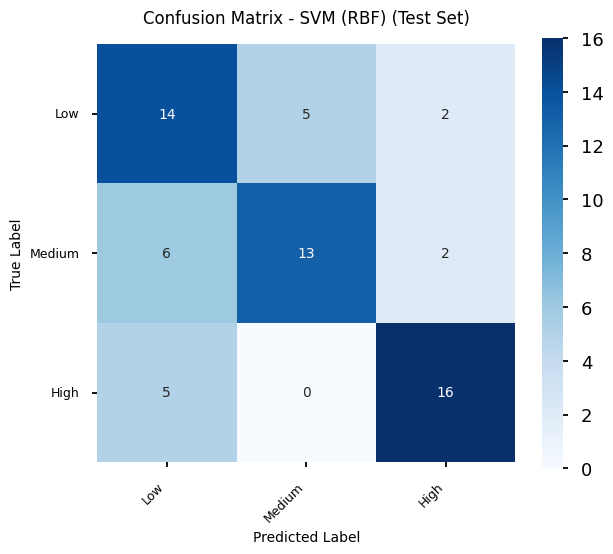

   - Plotting ROC Curve (One-vs-Rest)...
      Plot saved: SVM_(RBF)_roc_curve.png


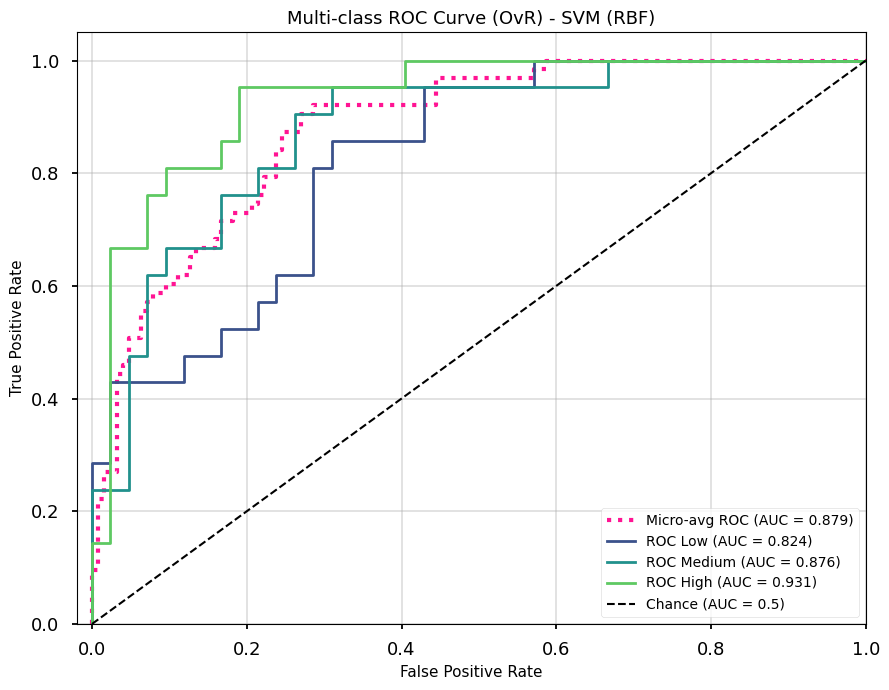

   - Plotting Precision-Recall Curve (One-vs-Rest)...
      Plot saved: SVM_(RBF)_precision_recall_curve.png


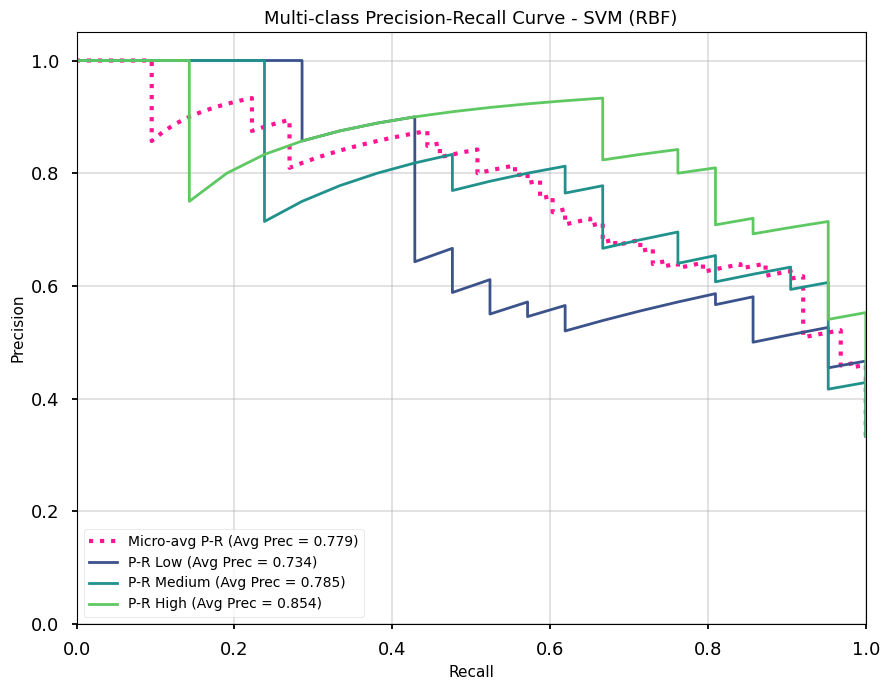


--- Classifier Evaluation Complete: SVM (RBF) ---

Fitting XGBoost...
   XGBoost fitted in 0.69 seconds.

--- Detailed CLASSIFIER Evaluation: XGBoost ---
--------------------------------------------

1. Generating Predictions & Probabilities...
   - Train predictions, Test predictions, Test probabilities generated.

2. Calculating Performance Metrics...
   - Balanced Accuracy (Train): 0.9894
   - Balanced Accuracy (Test):  0.6349
   - F1 Weighted (Test):        0.6338
   - F1 Macro (Test):           0.6338
   - Log Loss (Test):           0.7426
   - ROC AUC OvR Wgt (Test):    0.8526
   - Avg Precision Wgt (Test):  0.7706

3. Generating Summary Report Table...

Classifier Evaluation Summary: XGBoost
--------------------------------------
                       Metric  Score
      Train Balanced Accuracy 0.9894
       Test Balanced Accuracy 0.6349
           Test F1 (Weighted) 0.6338
              Test F1 (Macro) 0.6338
                Test Log Loss 0.7426
  Test ROC AUC (OVR Weighted) 

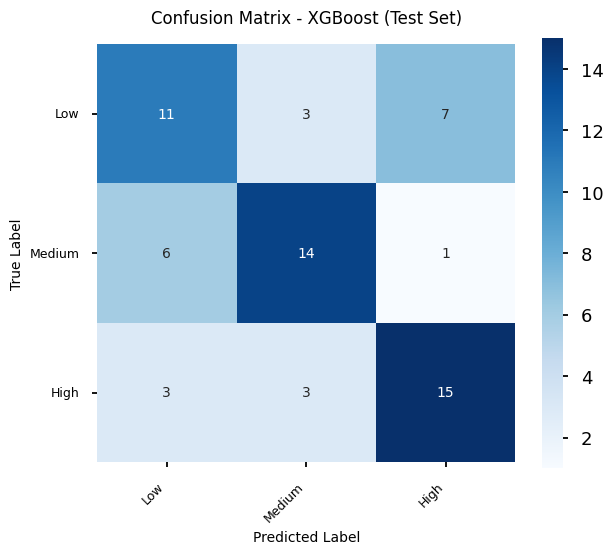

   - Plotting ROC Curve (One-vs-Rest)...
      Plot saved: XGBoost_roc_curve.png


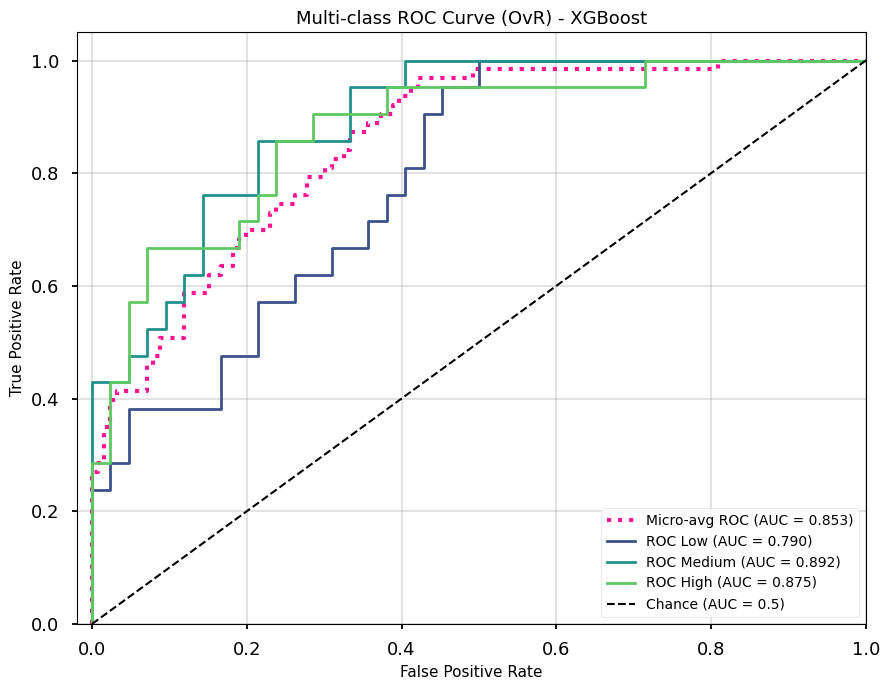

   - Plotting Precision-Recall Curve (One-vs-Rest)...
      Plot saved: XGBoost_precision_recall_curve.png


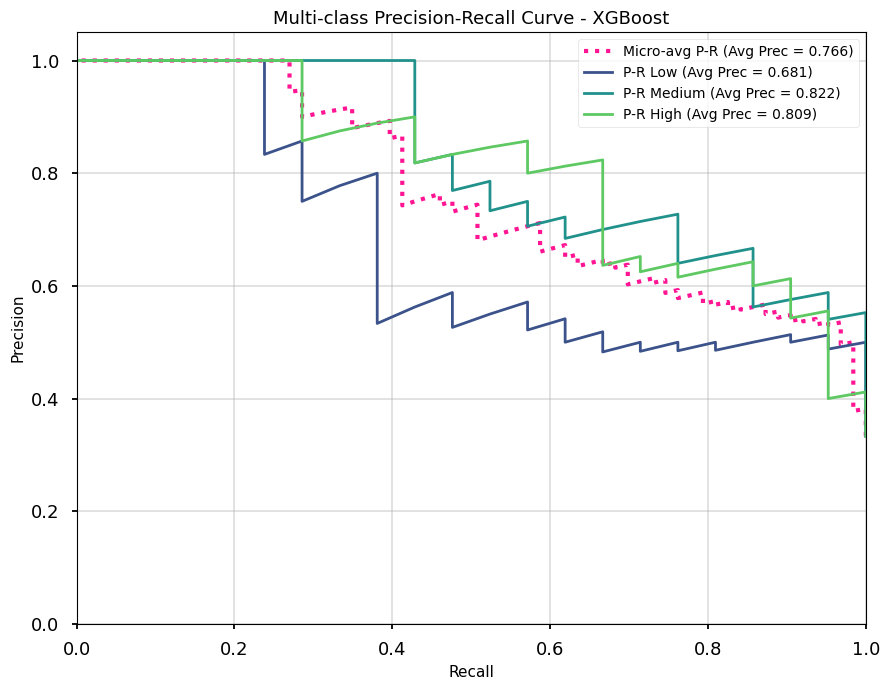


--- Classifier Evaluation Complete: XGBoost ---

--- Evaluating Selected Regressors ---

Fitting Ridge...
   Ridge fitted in 0.00 seconds.

--- Detailed REGRESSOR Evaluation: Ridge ---
------------------------------------------

1. Generating Predictions & Residuals...
   - Train predictions, Test predictions, Test residuals generated.

2. Calculating Performance Metrics...
   - RMSE (Train): 9.194
   - RMSE (Test):  10.082
   - R2 (Train):   0.998
   - R2 (Test):    0.997
   - MAE (Test):   7.814
   - MedAE (Test): 6.684
   - EVS (Test):   0.997
   - Max Err(Test):30.198

3. Generating Summary Report Table...

Regressor Evaluation Summary: Ridge
-----------------------------------
                 Metric  Score
             Train RMSE  9.194
              Test RMSE 10.082
               Train R2  0.998
                Test R2  0.997
               Test MAE  7.814
          Test MedianAE  6.684
Test Explained Variance  0.997
         Test Max Error 30.198
-----------------------------

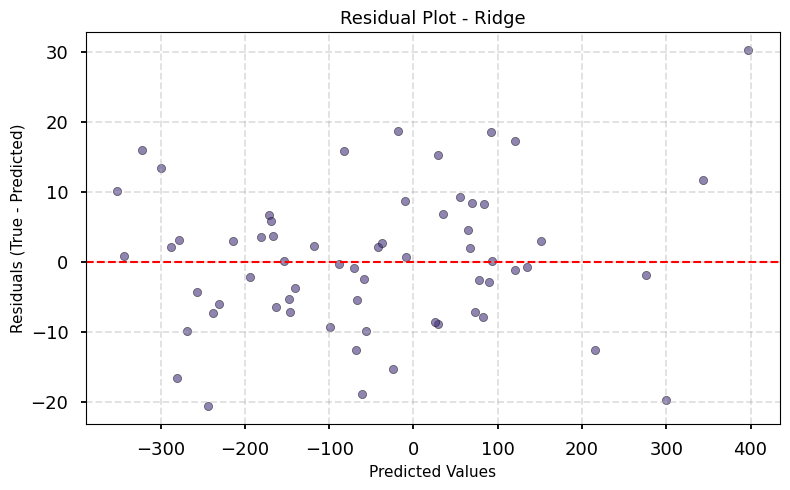

   - Plotting Q-Q Plot of Residuals...
      Plot saved: Ridge_residuals_qq_plot.png


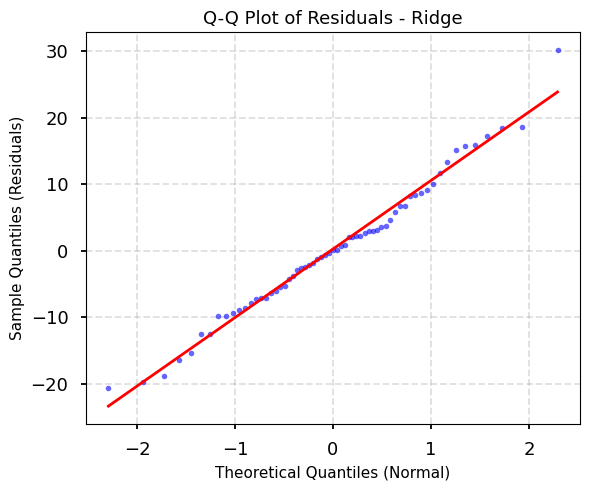

   - Plotting Prediction vs. Actual...
      Plot saved: Ridge_prediction_vs_actual.png


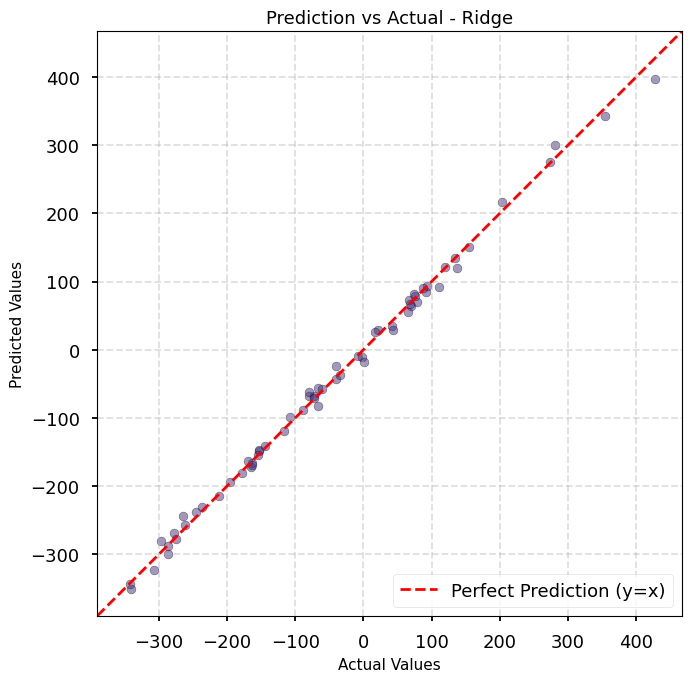

   - Plotting Distribution of Residuals...
      Plot saved: Ridge_residuals_distribution.png


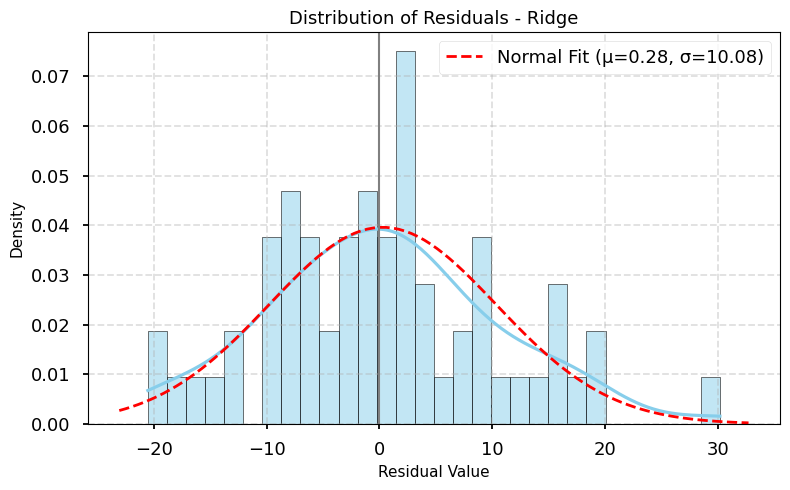


--- Regressor Evaluation Complete: Ridge ---

Fitting Gradient Boosting Reg...
   Gradient Boosting Reg fitted in 0.86 seconds.

--- Detailed REGRESSOR Evaluation: Gradient Boosting Reg ---
----------------------------------------------------------

1. Generating Predictions & Residuals...
   - Train predictions, Test predictions, Test residuals generated.

2. Calculating Performance Metrics...
   - RMSE (Train): 36.563
   - RMSE (Test):  95.321
   - R2 (Train):   0.965
   - R2 (Test):    0.695
   - MAE (Test):   78.138
   - MedAE (Test): 63.066
   - EVS (Test):   0.709
   - Max Err(Test):303.603

3. Generating Summary Report Table...

Regressor Evaluation Summary: Gradient Boosting Reg
---------------------------------------------------
                 Metric   Score
             Train RMSE  36.563
              Test RMSE  95.321
               Train R2   0.965
                Test R2   0.695
               Test MAE  78.138
          Test MedianAE  63.066
Test Explained Variance   0

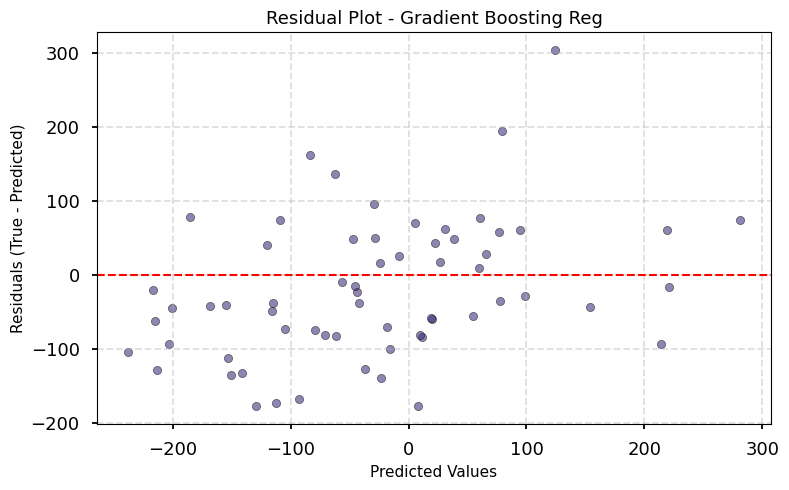

   - Plotting Q-Q Plot of Residuals...
      Plot saved: Gradient_Boosting_Reg_residuals_qq_plot.png


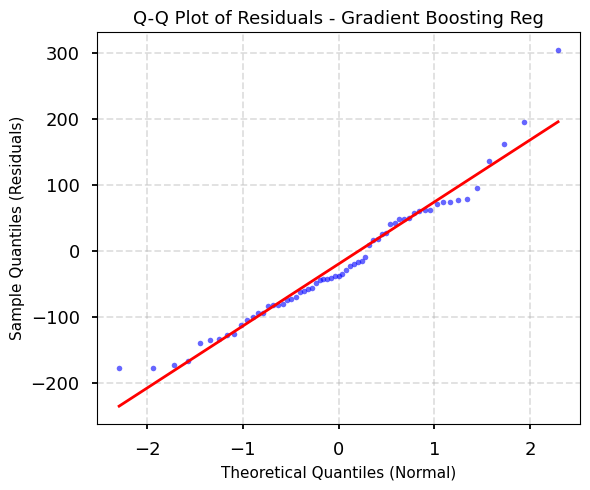

   - Plotting Prediction vs. Actual...
      Plot saved: Gradient_Boosting_Reg_prediction_vs_actual.png


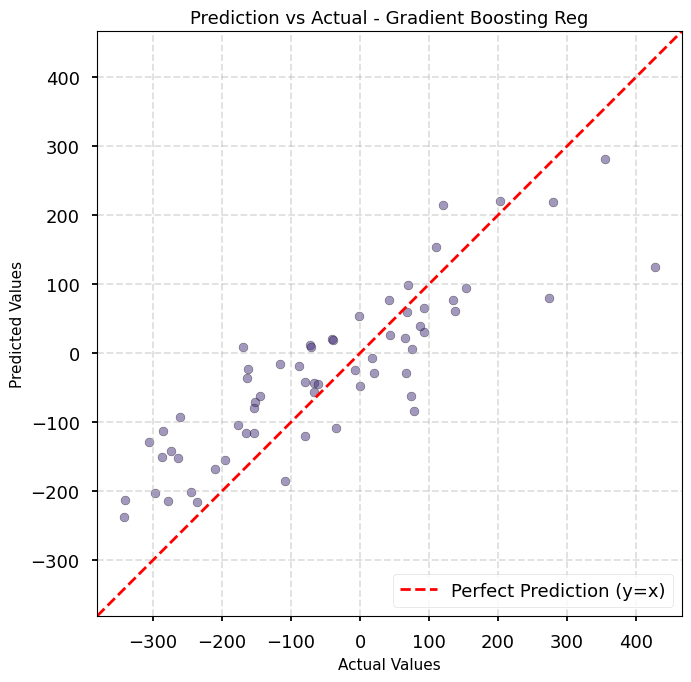

   - Plotting Distribution of Residuals...
      Plot saved: Gradient_Boosting_Reg_residuals_distribution.png


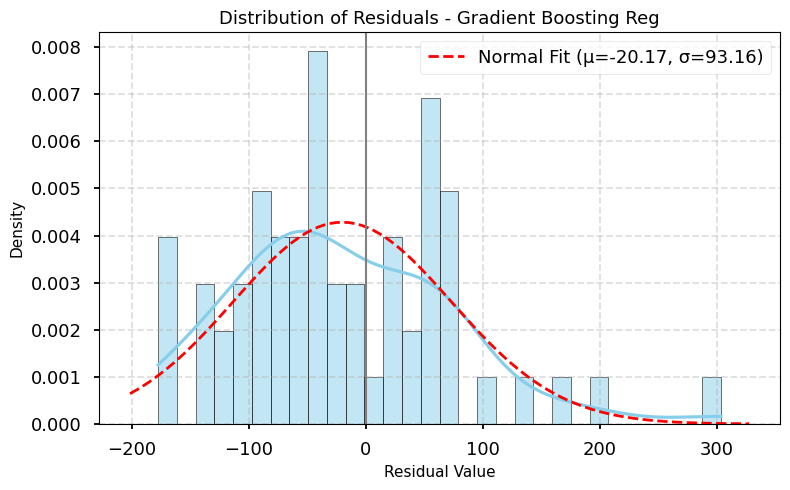


--- Regressor Evaluation Complete: Gradient Boosting Reg ---

--- Final Evaluation Comparison ---
----------------------------------------------------------------------

Classifier Test Balanced Accuracy Comparison
--------------------------------------------
    Model  Test Bal Acc
SVM (RBF)        0.6825
  XGBoost        0.6349
--------------------------------------------

Regressor Test RMSE Comparison
------------------------------
                Model  Test RMSE
                Ridge     10.082
Gradient Boosting Reg     95.321
------------------------------

Regression Model Summary (Formatted):
--------------------------------------------------------------------------------
| Model Name            |     MSE |   MAE |     R² |   Train RMSE |   Test RMSE | Remark For the Model                                                           |
|:----------------------|--------:|------:|-------:|-------------:|------------:|:----------------------------------------------------------------

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, log_loss, roc_auc_score, f1_score,
    balanced_accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, median_absolute_error, r2_score,
    explained_variance_score, max_error
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
try:
    import xgboost as xgb
    _XGB_INSTALLED = True
except ImportError:
    _XGB_INSTALLED = False
    print("Warning: XGBoost not installed. Skipping related models.")
try:
    import lightgbm as lgb
    _LGB_INSTALLED = True
except ImportError:
    _LGB_INSTALLED = False


from scipy import stats
import joblib
import os
from itertools import cycle
import time

# --- Assume these variables are pre-defined AND AVAILABLE in your environment ---
# --- THESE MUST BE POPULATED WITH YOUR ACTUAL DATA ---
# Example placeholders using dummy data (REPLACE THESE!)
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
SEED = 42
X_clf_d, y_clf_d = make_classification(n_samples=500, n_features=20, n_informative=10, n_redundant=5, n_classes=3, random_state=SEED)
X_reg_d, y_reg_d = make_regression(n_samples=500, n_features=20, n_informative=15, noise=10, random_state=SEED)
X_clf_d, _, y_clf_d, _ = train_test_split(X_clf_d, y_clf_d, train_size=0.5, random_state=SEED, stratify=y_clf_d)
X_reg_d, _, y_reg_d, _ = train_test_split(X_reg_d, y_reg_d, train_size=0.5, random_state=SEED)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf_d, y_clf_d, test_size=0.25, random_state=SEED, stratify=y_clf_d)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg_d, y_reg_d, test_size=0.25, random_state=SEED)
y_clf = y_clf_d # Original classification target Series/array
reverse_success_map = {0: 'Low', 1: 'Medium', 2: 'High'} # Example map
output_dir = "./final_evaluation_output" # Example output dir
# --- END OF PLACEHOLDERS - ENSURE YOUR VARIABLES ARE LOADED ---


# --- Default definitions if not available (for safety) ---
if 'COLOR' not in locals(): COLOR = {'BOLD': '', 'HEADER': '', 'YELLOW': '', 'RED': '', 'GREEN': '', 'END': ''}
if 'output_dir' not in locals(): output_dir = '.'
if 'reverse_success_map' not in locals(): reverse_success_map = {i: f'Class_{i}' for i in np.unique(y_clf)} # Default if not provided
if 'y_clf' not in locals() and 'y_test_clf' in locals(): y_clf = y_test_clf # Fallback for class names, less ideal

# --- Configuration ---
SAVE_ARTIFACTS = True  # Set to False to disable saving plots and reports
ARTIFACTS_SUBDIR = "evaluation_artifacts_top_models" # Subdirectory for saving

# --- Make sure base output dir exists ---
os.makedirs(output_dir, exist_ok=True)

# ==============================================================================
# --- Helper Functions (Keep these as they are) ---
# ==============================================================================
def _create_artifact_dir(model_name, task_type):
    safe_name = model_name.replace(" ", "_").replace("(", "").replace(")", "")
    subdir = os.path.join(output_dir, ARTIFACTS_SUBDIR, f"{safe_name}_{task_type}")
    if SAVE_ARTIFACTS: os.makedirs(subdir, exist_ok=True)
    return subdir
def _save_plot(fig, filename, artifact_dir):
    if not SAVE_ARTIFACTS: return
    try:
        filepath = os.path.join(artifact_dir, filename); fig.savefig(filepath, bbox_inches='tight', dpi=150)
        print(f"      Plot saved: {os.path.basename(filepath)}")
    except Exception as e: print(f"{COLOR['RED']}      ERROR saving plot {filename}: {e}{COLOR['END']}")
def _save_dataframe(df, filename, artifact_dir):
    if not SAVE_ARTIFACTS: return
    try:
        filepath = os.path.join(artifact_dir, filename); df.to_csv(filepath, index=(isinstance(df.index, pd.MultiIndex) or df.index.name is not None)) # Save index if named or multiindex
        print(f"      Report saved: {os.path.basename(filepath)}")
    except Exception as e: print(f"{COLOR['RED']}      ERROR saving report {filename}: {e}{COLOR['END']}")
def _display_table(df, title=""):
    print(f"\n{COLOR['BOLD']}{title}{COLOR['END']}"); hr = "-" * (len(title) if title else 40); print(hr)
    if df.empty: print("  (No data to display)")
    else: print(df.to_string(index=False)) # Usually false for summary tables
    print(hr)

# ==============================================================================
# --- Classifier Evaluation Function (Keep as is) ---
# ==============================================================================
def evaluate_classifier(model_pipeline, model_name, X_train, y_train, X_test, y_test, y_target_orig, artifact_dir):
    """Performs detailed evaluation for a classifier."""
    print(f"\n{COLOR['HEADER']}{COLOR['BOLD']}--- Detailed CLASSIFIER Evaluation: {model_name} ---{COLOR['END']}")
    print("-" * (37 + len(model_name)))
    results = {}
    # --- 1. Predictions & Probabilities ---
    print(f"\n{COLOR['BOLD']}1. Generating Predictions & Probabilities...{COLOR['END']}")
    try:
        y_pred_train = model_pipeline.predict(X_train)
        y_pred_test = model_pipeline.predict(X_test)
        results['y_pred_test'] = y_pred_test
        y_prob_test = None
        if hasattr(model_pipeline, "predict_proba"):
            y_prob_test = model_pipeline.predict_proba(X_test)
            results['y_prob_test'] = y_prob_test
            print("   - Train predictions, Test predictions, Test probabilities generated.")
        else:
            print("   - Train predictions, Test predictions generated.")
            print(f"   {COLOR['YELLOW']}Warning: Model does not support predict_proba.{COLOR['END']}")
    except Exception as e: print(f"{COLOR['RED']}   ERROR during prediction: {e}{COLOR['END']}"); return None
    # --- 2. Calculate Metrics ---
    print(f"\n{COLOR['BOLD']}2. Calculating Performance Metrics...{COLOR['END']}")
    try:
        results['train_bal_acc'] = balanced_accuracy_score(y_train, y_pred_train)
        results['test_bal_acc'] = balanced_accuracy_score(y_test, y_pred_test)
        results['test_f1_weighted'] = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
        results['test_f1_macro'] = f1_score(y_test, y_pred_test, average='macro', zero_division=0)
        print(f"   - Balanced Accuracy (Train): {results['train_bal_acc']:.4f}")
        print(f"   - Balanced Accuracy (Test):  {results['test_bal_acc']:.4f}")
        print(f"   - F1 Weighted (Test):        {results['test_f1_weighted']:.4f}")
        print(f"   - F1 Macro (Test):           {results['test_f1_macro']:.4f}")
        results['test_log_loss'] = None; results['test_roc_auc_ovr_w'] = None; results['test_avg_prec_w'] = None
        unique_classes_orig = sorted(np.unique(y_target_orig)); unique_classes_test = sorted(np.unique(y_test))
        n_classes_orig = len(unique_classes_orig)
        class_names = [reverse_success_map.get(i, f'Class_{i}') for i in unique_classes_orig]
        if y_prob_test is not None and n_classes_orig > 1 and len(unique_classes_test) > 1:
             if y_prob_test.shape[1] == len(unique_classes_orig):
                try: results['test_log_loss'] = log_loss(y_test, y_prob_test, labels=unique_classes_orig); print(f"   - Log Loss (Test):           {results['test_log_loss']:.4f}")
                except ValueError as e: print(f"   {COLOR['YELLOW']}Warning: Log Loss failed: {e}{COLOR['END']}")
                y_test_bin = label_binarize(y_test, classes=unique_classes_orig)
                if y_test_bin.shape[1] == y_prob_test.shape[1]:
                    try: results['test_roc_auc_ovr_w'] = roc_auc_score(y_test_bin, y_prob_test, multi_class='ovr', average='weighted'); print(f"   - ROC AUC OvR Wgt (Test):    {results['test_roc_auc_ovr_w']:.4f}")
                    except ValueError as e: print(f"   {COLOR['YELLOW']}Warning: ROC AUC failed: {e}{COLOR['END']}")
                    try: results['test_avg_prec_w'] = average_precision_score(y_test_bin, y_prob_test, average='weighted'); print(f"   - Avg Precision Wgt (Test):  {results['test_avg_prec_w']:.4f}")
                    except Exception as e: print(f"   {COLOR['YELLOW']}Warning: Avg Precision failed: {e}{COLOR['END']}")
                else: print(f"   {COLOR['YELLOW']}Warning: Binarized label shape mismatch. Skipping ROC AUC / Avg Precision.{COLOR['END']}")
             else: print(f"   {COLOR['YELLOW']}Warning: Prob shape mismatch. Skipping prob metrics.{COLOR['END']}")
        else: print(f"   {COLOR['YELLOW']}Skipping probability-based metrics.{COLOR['END']}")
    except Exception as e: print(f"{COLOR['RED']}   ERROR calculating metrics: {e}{COLOR['END']}")
    # --- 3. Summary Table ---
    print(f"\n{COLOR['BOLD']}3. Generating Summary Report Table...{COLOR['END']}")
    summary_data = [
        ("Train Balanced Accuracy", f"{results.get('train_bal_acc', 'N/A'):.4f}" if isinstance(results.get('train_bal_acc'), (int, float)) else "N/A"),
        ("Test Balanced Accuracy", f"{results.get('test_bal_acc', 'N/A'):.4f}" if isinstance(results.get('test_bal_acc'), (int, float)) else "N/A"),
        ("Test F1 (Weighted)", f"{results.get('test_f1_weighted', 'N/A'):.4f}" if isinstance(results.get('test_f1_weighted'), (int, float)) else "N/A"),
        ("Test F1 (Macro)", f"{results.get('test_f1_macro', 'N/A'):.4f}" if isinstance(results.get('test_f1_macro'), (int, float)) else "N/A"),
        ("Test Log Loss", f"{results.get('test_log_loss', 'N/A'):.4f}" if results.get('test_log_loss') is not None else "N/A"),
        ("Test ROC AUC (OVR Weighted)", f"{results.get('test_roc_auc_ovr_w', 'N/A'):.4f}" if results.get('test_roc_auc_ovr_w') is not None else "N/A"),
        ("Test Avg Precision (Weighted)", f"{results.get('test_avg_prec_w', 'N/A'):.4f}" if results.get('test_avg_prec_w') is not None else "N/A")
    ]
    clf_summary_df = pd.DataFrame(summary_data, columns=["Metric", "Score"])
    _display_table(clf_summary_df, f"Classifier Evaluation Summary: {model_name}")
    _save_dataframe(clf_summary_df, f"{model_name.replace(' ', '_')}_summary_metrics.csv", artifact_dir)
    # --- 4. Classification Report ---
    print(f"\n{COLOR['BOLD']}4. Generating Classification Report (Per Class)...{COLOR['END']}")
    try:
        report = classification_report(y_test, y_pred_test, labels=unique_classes_orig, target_names=class_names, zero_division=0)
        print("\nClassification Report (Test Set):")
        print(report)
        if SAVE_ARTIFACTS:
            report_path = os.path.join(artifact_dir, f"{model_name.replace(' ', '_')}_classification_report.txt")
            with open(report_path, 'w') as f: f.write(f"Classification Report for: {model_name}\n{'='*50}\n{report}"); print(f"      Report saved: {os.path.basename(report_path)}")
        report_dict = classification_report(y_test, y_pred_test, labels=unique_classes_orig, target_names=class_names, zero_division=0, output_dict=True)
        clf_report_df = pd.DataFrame(report_dict).transpose(); clf_report_df.index.name = 'Class/Avg'; clf_report_df.reset_index(inplace=True)
        _save_dataframe(clf_report_df, f"{model_name.replace(' ', '_')}_classification_report.csv", artifact_dir)
    except Exception as report_e: print(f"{COLOR['RED']}   ERROR generating classification report: {report_e}{COLOR['END']}")
    # --- 5. Generate Plots (Keep Confusion Matrix, ROC, PR) ---
    print(f"\n{COLOR['BOLD']}5. Generating Plots...{COLOR['END']}")
    # Plot 1: Confusion Matrix
    print("   - Plotting Confusion Matrix...")
    try:
        cm = confusion_matrix(y_test, y_pred_test, labels=unique_classes_orig); fig_cm, ax_cm = plt.subplots(figsize=(len(class_names)*1.8+1, len(class_names)*1.5+1))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm, xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 10}, square=True, cbar=True)
        ax_cm.set_title(f'Confusion Matrix - {model_name} (Test Set)', fontsize=12, pad=15); ax_cm.set_xlabel('Predicted Label', fontsize=10); ax_cm.set_ylabel('True Label', fontsize=10)
        plt.xticks(rotation=45, ha='right', fontsize=9); plt.yticks(rotation=0, fontsize=9); plt.tight_layout()
        _save_plot(fig_cm, f"{model_name.replace(' ', '_')}_confusion_matrix.png", artifact_dir); plt.show(); plt.close(fig_cm)
    except Exception as cm_e: print(f"{COLOR['RED']}     ERROR plotting Confusion Matrix: {cm_e}{COLOR['END']}"); plt.close('all')
    # Plot 2: ROC Curve
    can_plot_roc_pr = (y_prob_test is not None and n_classes_orig > 1 and len(unique_classes_test) > 1 and y_prob_test.shape[1] == n_classes_orig)
    if can_plot_roc_pr:
        print("   - Plotting ROC Curve (One-vs-Rest)...")
        try:
            y_test_bin = label_binarize(y_test, classes=unique_classes_orig); fpr, tpr, roc_auc_dict = dict(), dict(), dict()
            for i in range(n_classes_orig): fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob_test[:, i]); roc_auc_dict[i] = auc(fpr[i], tpr[i])
            fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob_test.ravel()); roc_auc_dict["micro"] = auc(fpr["micro"], tpr["micro"])
            fig_roc, ax_roc = plt.subplots(figsize=(9, 7)); colors = cycle(sns.color_palette("viridis", n_classes_orig))
            ax_roc.plot(fpr["micro"], tpr["micro"], label=f'Micro-avg ROC (AUC = {roc_auc_dict["micro"]:0.3f})', color='deeppink', linestyle=':', linewidth=3)
            for i, color in zip(range(n_classes_orig), colors): ax_roc.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC {class_names[i]} (AUC = {roc_auc_dict[i]:0.3f})')
            ax_roc.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Chance (AUC = 0.5)'); ax_roc.set_xlim([-0.02, 1.0]); ax_roc.set_ylim([0.0, 1.05])
            ax_roc.set_xlabel('False Positive Rate', fontsize=11); ax_roc.set_ylabel('True Positive Rate', fontsize=11); ax_roc.set_title(f'Multi-class ROC Curve (OvR) - {model_name}', fontsize=13)
            ax_roc.legend(loc="lower right", fontsize='medium'); ax_roc.grid(alpha=0.4); plt.tight_layout()
            _save_plot(fig_roc, f"{model_name.replace(' ', '_')}_roc_curve.png", artifact_dir); plt.show(); plt.close(fig_roc)
        except Exception as roc_e: print(f"{COLOR['RED']}     ERROR plotting ROC Curve: {roc_e}{COLOR['END']}"); plt.close('all')
    else: print(f"   {COLOR['YELLOW']}Skipping ROC Curve plot.{COLOR['END']}")
    # Plot 3: Precision-Recall Curve
    if can_plot_roc_pr:
        print("   - Plotting Precision-Recall Curve (One-vs-Rest)...")
        try:
            y_test_bin = label_binarize(y_test, classes=unique_classes_orig); precision, recall, avg_prec = dict(), dict(), dict()
            for i in range(n_classes_orig): precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_prob_test[:, i]); avg_prec[i] = average_precision_score(y_test_bin[:, i], y_prob_test[:, i])
            precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_prob_test.ravel()); avg_prec["micro"] = average_precision_score(y_test_bin, y_prob_test, average="micro")
            fig_pr, ax_pr = plt.subplots(figsize=(9, 7)); colors = cycle(sns.color_palette("viridis", n_classes_orig))
            ax_pr.plot(recall["micro"], precision["micro"], label=f'Micro-avg P-R (Avg Prec = {avg_prec["micro"]:0.3f})', color='deeppink', linestyle=':', linewidth=3)
            for i, color in zip(range(n_classes_orig), colors): ax_pr.plot(recall[i], precision[i], color=color, lw=2, label=f'P-R {class_names[i]} (Avg Prec = {avg_prec[i]:0.3f})')
            ax_pr.set_xlim([0.0, 1.0]); ax_pr.set_ylim([0.0, 1.05]); ax_pr.set_xlabel('Recall', fontsize=11); ax_pr.set_ylabel('Precision', fontsize=11); ax_pr.set_title(f'Multi-class Precision-Recall Curve - {model_name}', fontsize=13)
            ax_pr.legend(loc="best", fontsize='medium'); ax_pr.grid(alpha=0.4); plt.tight_layout()
            _save_plot(fig_pr, f"{model_name.replace(' ', '_')}_precision_recall_curve.png", artifact_dir); plt.show(); plt.close(fig_pr)
        except Exception as pr_e: print(f"{COLOR['RED']}     ERROR plotting Precision-Recall Curve: {pr_e}{COLOR['END']}"); plt.close('all')
    else: print(f"   {COLOR['YELLOW']}Skipping Precision-Recall Curve plot.{COLOR['END']}")
    print(f"\n{COLOR['GREEN']}--- Classifier Evaluation Complete: {model_name} ---{COLOR['END']}")
    return results

# ==============================================================================
# --- Regressor Evaluation Function (Keep as is) ---
# ==============================================================================
def evaluate_regressor(model_pipeline, model_name, X_train, y_train, X_test, y_test, artifact_dir):
    """Performs detailed evaluation for a regressor."""
    print(f"\n{COLOR['HEADER']}{COLOR['BOLD']}--- Detailed REGRESSOR Evaluation: {model_name} ---{COLOR['END']}")
    print("-" * (37 + len(model_name)))
    results = {}
    # --- 1. Predictions & Residuals ---
    print(f"\n{COLOR['BOLD']}1. Generating Predictions & Residuals...{COLOR['END']}")
    try:
        y_pred_train = model_pipeline.predict(X_train)
        y_pred_test = model_pipeline.predict(X_test)
        residuals_test = y_test - y_pred_test
        results['y_pred_test'] = y_pred_test; results['residuals_test'] = residuals_test
        print("   - Train predictions, Test predictions, Test residuals generated.")
    except Exception as e: print(f"{COLOR['RED']}   ERROR during prediction: {e}{COLOR['END']}"); return None
    # --- 2. Calculate Metrics ---
    print(f"\n{COLOR['BOLD']}2. Calculating Performance Metrics...{COLOR['END']}")
    try:
        results['train_rmse'] = np.sqrt(mean_squared_error(y_train, y_pred_train)); results['test_rmse'] = np.sqrt(mean_squared_error(y_test, y_pred_test))
        results['train_r2'] = r2_score(y_train, y_pred_train); results['test_r2'] = r2_score(y_test, y_pred_test)
        results['test_mae'] = mean_absolute_error(y_test, y_pred_test); results['test_medae'] = median_absolute_error(y_test, y_pred_test)
        results['test_evs'] = explained_variance_score(y_test, y_pred_test); results['test_max_err'] = max_error(y_test, y_pred_test)
        print(f"   - RMSE (Train): {results['train_rmse']:.3f}"); print(f"   - RMSE (Test):  {results['test_rmse']:.3f}")
        print(f"   - R2 (Train):   {results['train_r2']:.3f}"); print(f"   - R2 (Test):    {results['test_r2']:.3f}")
        print(f"   - MAE (Test):   {results['test_mae']:.3f}"); print(f"   - MedAE (Test): {results['test_medae']:.3f}")
        print(f"   - EVS (Test):   {results['test_evs']:.3f}"); print(f"   - Max Err(Test):{results['test_max_err']:.3f}")
    except Exception as e: print(f"{COLOR['RED']}   ERROR calculating metrics: {e}{COLOR['END']}")
    # --- 3. Summary Table ---
    print(f"\n{COLOR['BOLD']}3. Generating Summary Report Table...{COLOR['END']}")
    summary_data = [
        ("Train RMSE", f"{results.get('train_rmse', 'N/A'):.3f}" if isinstance(results.get('train_rmse'), (int, float)) else "N/A"),
        ("Test RMSE", f"{results.get('test_rmse', 'N/A'):.3f}" if isinstance(results.get('test_rmse'), (int, float)) else "N/A"),
        ("Train R2", f"{results.get('train_r2', 'N/A'):.3f}" if isinstance(results.get('train_r2'), (int, float)) else "N/A"),
        ("Test R2", f"{results.get('test_r2', 'N/A'):.3f}" if isinstance(results.get('test_r2'), (int, float)) else "N/A"),
        ("Test MAE", f"{results.get('test_mae', 'N/A'):.3f}" if isinstance(results.get('test_mae'), (int, float)) else "N/A"),
        ("Test MedianAE", f"{results.get('test_medae', 'N/A'):.3f}" if isinstance(results.get('test_medae'), (int, float)) else "N/A"),
        ("Test Explained Variance", f"{results.get('test_evs', 'N/A'):.3f}" if isinstance(results.get('test_evs'), (int, float)) else "N/A"),
        ("Test Max Error", f"{results.get('test_max_err', 'N/A'):.3f}" if isinstance(results.get('test_max_err'), (int, float)) else "N/A")
    ]
    reg_summary_df = pd.DataFrame(summary_data, columns=["Metric", "Score"])
    _display_table(reg_summary_df, f"Regressor Evaluation Summary: {model_name}")
    _save_dataframe(reg_summary_df, f"{model_name.replace(' ', '_')}_summary_metrics.csv", artifact_dir)
    # --- 4. Generate Plots (Keep Residuals, QQ, PvA, Residual Dist) ---
    print(f"\n{COLOR['BOLD']}4. Generating Plots...{COLOR['END']}")
    # Plot 1: Residuals vs. Predicted
    print("   - Plotting Residuals vs. Predicted...")
    try:
        fig_res, ax_res = plt.subplots(figsize=(8, 5)); sns.scatterplot(x=y_pred_test, y=residuals_test, ax=ax_res, alpha=0.6, edgecolor='k', s=35)
        ax_res.axhline(0, color='red', linestyle='--', lw=1.5); ax_res.set_xlabel('Predicted Values', fontsize=11); ax_res.set_ylabel('Residuals (True - Predicted)', fontsize=11)
        ax_res.set_title(f'Residual Plot - {model_name}', fontsize=13); ax_res.grid(True, linestyle='--', alpha=0.4); plt.tight_layout()
        _save_plot(fig_res, f"{model_name.replace(' ', '_')}_residuals_vs_predicted.png", artifact_dir); plt.show(); plt.close(fig_res)
    except Exception as res_e: print(f"{COLOR['RED']}     ERROR plotting Residuals vs Predicted: {res_e}{COLOR['END']}"); plt.close('all')
    # Plot 2: Q-Q Plot
    print("   - Plotting Q-Q Plot of Residuals...")
    try:
        fig_qq, ax_qq = plt.subplots(figsize=(6, 5)); res = stats.probplot(residuals_test, dist="norm", plot=ax_qq)
        ax_qq.get_lines()[0].set_marker('o'); ax_qq.get_lines()[0].set_markersize(4.0); ax_qq.get_lines()[0].set_markeredgecolor('k'); ax_qq.get_lines()[0].set_alpha(0.6)
        ax_qq.get_lines()[1].set_color('red'); ax_qq.get_lines()[1].set_linewidth(2.0); ax_qq.set_title(f'Q-Q Plot of Residuals - {model_name}', fontsize=13)
        ax_qq.set_xlabel('Theoretical Quantiles (Normal)', fontsize=11); ax_qq.set_ylabel('Sample Quantiles (Residuals)', fontsize=11); ax_qq.grid(True, linestyle='--', alpha=0.4); plt.tight_layout()
        _save_plot(fig_qq, f"{model_name.replace(' ', '_')}_residuals_qq_plot.png", artifact_dir); plt.show(); plt.close(fig_qq)
    except Exception as qq_e: print(f"{COLOR['RED']}     ERROR plotting Q-Q Plot: {qq_e}{COLOR['END']}"); plt.close('all')
    # Plot 3: Prediction vs Actual
    print("   - Plotting Prediction vs. Actual...")
    try:
        fig_pvsa, ax_pvsa = plt.subplots(figsize=(7, 7)); min_val = min(y_test.min(), y_pred_test.min()); max_val = max(y_test.max(), y_pred_test.max()); range_val = max_val - min_val
        plot_min = min_val - 0.05 * range_val; plot_max = max_val + 0.05 * range_val
        ax_pvsa.scatter(y_test, y_pred_test, alpha=0.5, edgecolor='k', s=40); ax_pvsa.plot([plot_min, plot_max], [plot_min, plot_max], 'r--', lw=2, label='Perfect Prediction (y=x)')
        ax_pvsa.set_xlabel('Actual Values', fontsize=11); ax_pvsa.set_ylabel('Predicted Values', fontsize=11); ax_pvsa.set_title(f'Prediction vs Actual - {model_name}', fontsize=13)
        ax_pvsa.set_xlim(plot_min, plot_max); ax_pvsa.set_ylim(plot_min, plot_max); ax_pvsa.legend(loc='lower right'); ax_pvsa.grid(True, linestyle='--', alpha=0.4); ax_pvsa.set_aspect('equal', adjustable='box'); plt.tight_layout()
        _save_plot(fig_pvsa, f"{model_name.replace(' ', '_')}_prediction_vs_actual.png", artifact_dir); plt.show(); plt.close(fig_pvsa)
    except Exception as pvsa_e: print(f"{COLOR['RED']}     ERROR plotting Prediction vs Actual: {pvsa_e}{COLOR['END']}"); plt.close('all')
    # Plot 4: Residual Distribution
    print("   - Plotting Distribution of Residuals...")
    try:
        fig_res_dist, ax_res_dist = plt.subplots(figsize=(8, 5)); sns.histplot(residuals_test, kde=True, ax=ax_res_dist, bins=30, stat="density", color='skyblue', edgecolor='black')
        mu, std = stats.norm.fit(residuals_test); xmin, xmax = plt.xlim(); x = np.linspace(xmin, xmax, 100); p = stats.norm.pdf(x, mu, std)
        ax_res_dist.plot(x, p, 'r--', linewidth=2, label=f'Normal Fit (μ={mu:.2f}, σ={std:.2f})'); ax_res_dist.set_xlabel('Residual Value', fontsize=11); ax_res_dist.set_ylabel('Density', fontsize=11)
        ax_res_dist.set_title(f'Distribution of Residuals - {model_name}', fontsize=13); ax_res_dist.axvline(0, color='grey', linestyle='-', lw=1.5); ax_res_dist.legend(); ax_res_dist.grid(True, linestyle='--', alpha=0.4); plt.tight_layout()
        _save_plot(fig_res_dist, f"{model_name.replace(' ', '_')}_residuals_distribution.png", artifact_dir); plt.show(); plt.close(fig_res_dist)
    except Exception as res_dist_e: print(f"{COLOR['RED']}     ERROR plotting Residual Distribution: {res_dist_e}{COLOR['END']}"); plt.close('all')
    print(f"\n{COLOR['GREEN']}--- Regressor Evaluation Complete: {model_name} ---{COLOR['END']}")
    return results

# ==============================================================================
# --- Main Execution Block (Modified for Manual Evaluation) ---
# ==============================================================================

print(f"\n{COLOR['BOLD']}{COLOR['HEADER']}--- (9) Detailed Evaluation for Selected Top Models ---{COLOR['END']}")
print("=" * 95)

# --- Define Pipelines with BEST PARAMETERS found previously ---
preprocessor = StandardScaler()

# --- CLASSIFIERS TO EVALUATE ---
models_to_evaluate_clf = {}
# 1. SVM (RBF)
svm_pipeline = Pipeline([('scaler', preprocessor), ('model', SVC(C=50, gamma=0.01, probability=True, random_state=SEED, cache_size=500))])
models_to_evaluate_clf['SVM (RBF)'] = svm_pipeline
# 2. XGBoost
if _XGB_INSTALLED:
    xgb_pipeline = Pipeline([('scaler', preprocessor), ('model', xgb.XGBClassifier(subsample=0.7, reg_lambda=0.5, reg_alpha=0, n_estimators=400, max_depth=3, learning_rate=0.01, colsample_bytree=0.7, random_state=SEED, use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1))])
    models_to_evaluate_clf['XGBoost'] = xgb_pipeline
else: print(f"{COLOR['YELLOW']}Skipping XGBoost evaluation as it's not installed.{COLOR['END']}")

# --- REGRESSORS TO EVALUATE ---
models_to_evaluate_reg = {}
# 1. Ridge
ridge_pipeline = Pipeline([('scaler', preprocessor), ('model', Ridge(alpha=0.1, random_state=SEED))])
models_to_evaluate_reg['Ridge'] = ridge_pipeline
# 2. Gradient Boosting Reg
gb_reg_pipeline = Pipeline([('scaler', preprocessor), ('model', GradientBoostingRegressor(subsample=0.7, n_estimators=500, min_samples_split=15, min_samples_leaf=7, max_depth=3, learning_rate=0.01, random_state=SEED))])
models_to_evaluate_reg['Gradient Boosting Reg'] = gb_reg_pipeline

# --- Perform Detailed Evaluation for selected models ---
all_clf_results = {}
all_reg_results = {}

print(f"\n{COLOR['BOLD']}--- Evaluating Selected Classifiers ---{COLOR['END']}")
for model_name, model_pipeline in models_to_evaluate_clf.items():
    print(f"\n{COLOR['BLUE']}Fitting {model_name}...{COLOR['END']}")
    try:
        start_fit = time.time(); model_pipeline.fit(X_train_clf, y_train_clf); fit_time = time.time() - start_fit
        print(f"   {model_name} fitted in {fit_time:.2f} seconds.")
        clf_artifact_dir = _create_artifact_dir(model_name, "Classifier_TopEval")
        results = evaluate_classifier(model_pipeline, model_name, X_train_clf, y_train_clf, X_test_clf, y_test_clf, y_clf, clf_artifact_dir)
        if results: all_clf_results[model_name] = results
    except Exception as fit_eval_e: print(f"{COLOR['RED']}ERROR during fitting or evaluation of {model_name}: {fit_eval_e}{COLOR['END']}")

print(f"\n{COLOR['BOLD']}--- Evaluating Selected Regressors ---{COLOR['END']}")
for model_name, model_pipeline in models_to_evaluate_reg.items():
    print(f"\n{COLOR['BLUE']}Fitting {model_name}...{COLOR['END']}")
    try:
        start_fit = time.time(); model_pipeline.fit(X_train_reg, y_train_reg); fit_time = time.time() - start_fit
        print(f"   {model_name} fitted in {fit_time:.2f} seconds.")
        reg_artifact_dir = _create_artifact_dir(model_name, "Regressor_TopEval")
        results = evaluate_regressor(model_pipeline, model_name, X_train_reg, y_train_reg, X_test_reg, y_test_reg, reg_artifact_dir)
        if results: all_reg_results[model_name] = results
    except Exception as fit_eval_e: print(f"{COLOR['RED']}ERROR during fitting or evaluation of {model_name}: {fit_eval_e}{COLOR['END']}")

# --- Generate Final Comparison Tables (including the requested format) ---
print(f"\n{COLOR['HEADER']}{COLOR['BOLD']}--- Final Evaluation Comparison ---{COLOR['END']}")
print("-" * 70)

# --- Classifier Comparison ---
clf_summary_comp = []
for name, results in all_clf_results.items():
    clf_summary_comp.append({'Model': name, 'Test Bal Acc': results.get('test_bal_acc', np.nan)})
if clf_summary_comp:
    clf_comp_df = pd.DataFrame(clf_summary_comp).sort_values('Test Bal Acc', ascending=False).round(4)
    _display_table(clf_comp_df, "Classifier Test Balanced Accuracy Comparison")

# --- Regressor Comparison (Standard) ---
reg_summary_comp = []
for name, results in all_reg_results.items():
     reg_summary_comp.append({'Model': name, 'Test RMSE': results.get('test_rmse', np.nan)})
if reg_summary_comp:
    reg_comp_df = pd.DataFrame(reg_summary_comp).sort_values('Test RMSE', ascending=True).round(3)
    _display_table(reg_comp_df, "Regressor Test RMSE Comparison")

# --- *** NEW: Generate Regressor Table in Requested Format *** ---
print(f"\n{COLOR['BOLD']}Regression Model Summary (Formatted):{COLOR['END']}")
print("-" * 80)
formatted_reg_data = []
for name, results in all_reg_results.items():
    if not results: continue # Skip if evaluation failed
    test_rmse = results.get('test_rmse')
    train_rmse = results.get('train_rmse')
    test_mae = results.get('test_mae')
    test_r2 = results.get('test_r2')
    test_mse = test_rmse**2 if test_rmse is not None else None

    # Determine Remark
    remark = "Evaluation Incomplete"
    if train_rmse is not None and test_rmse is not None and test_r2 is not None:
        overfitting_level = "Low"
        if test_rmse > 1e-6: # Avoid division by zero
            ratio = train_rmse / test_rmse
            if ratio < 0.7: overfitting_level = "High"
            elif ratio < 0.9: overfitting_level = "Moderate"

        if test_r2 < 0.3:
            remark = f"Poor performance, Underfitting? (R²={test_r2:.3f})"
        elif test_r2 < 0.6:
             remark = f"Moderate performance. Overfitting: {overfitting_level} (R²={test_r2:.3f})"
        elif test_r2 < 0.9:
             remark = f"Good performance. Overfitting: {overfitting_level} (R²={test_r2:.3f})"
        else: # R2 >= 0.9
            if overfitting_level in ["High", "Moderate"]:
                 remark = f"Excellent R², but Overfitting: {overfitting_level} (R²={test_r2:.3f})"
            else:
                 remark = f"Excellent performance and generalization (R²={test_r2:.3f})"
        # Specific override for Ridge based on previous results
        if name == 'Ridge' and test_r2 > 0.99 and overfitting_level == "Low":
             remark = "Outstanding performance. Very low error, near-perfect R², minimal overfitting."


    formatted_reg_data.append({
        'Model Name': name,
        'MSE': f"{test_mse:.2f}" if test_mse is not None else "N/A",
        'MAE': f"{test_mae:.2f}" if test_mae is not None else "N/A",
        'R²': f"{test_r2:.4f}" if test_r2 is not None else "N/A",
        'Train RMSE': f"{train_rmse:.3f}" if train_rmse is not None else "N/A",
        'Test RMSE': f"{test_rmse:.3f}" if test_rmse is not None else "N/A",
        'Remark For the Model': remark
    })

if formatted_reg_data:
    formatted_reg_df = pd.DataFrame(formatted_reg_data)
    # Display using markdown for better formatting in compatible environments
    try:
        print(formatted_reg_df.to_markdown(index=False))
    except ImportError: # Fallback if tabulate not installed
        print(formatted_reg_df.to_string(index=False))

    # Save this formatted table too
    _save_dataframe(formatted_reg_df, "formatted_regressor_summary.csv", os.path.join(output_dir, ARTIFACTS_SUBDIR))
else:
    print("  (No regressor results to format)")
print("-" * 80)
# --- End of New Table Generation ---


print(f"\n{COLOR['GREEN']}--- Section 9: Detailed Evaluation for Top Models Complete ---{COLOR['END']}")
print("="*95)

In [46]:
# Ensure necessary imports are available from the previous block
import joblib
import os
import numpy as np # For np.unique
import pandas as pd # For pd.MultiIndex check if needed

# --- Assume these variables are defined and available from previous blocks ---
# svm_pipeline (fitted Pipeline object for SVM)
# ridge_pipeline (fitted Pipeline object for Ridge)
# output_dir (path string)
# y_clf (original classification target) # Needed for default map generation
# COLOR (dictionary) # Optional

# --- Default definitions if not available (for safety) ---
if 'COLOR' not in locals(): COLOR = {'BOLD': '', 'HEADER': '', 'YELLOW': '', 'RED': '', 'GREEN': '', 'END': ''}
if 'output_dir' not in locals(): output_dir = '.'
if 'success_map' not in locals(): success_map = {'Low': 0, 'Medium': 1, 'High': 2} # Default if not provided
if 'severity_map' not in locals(): severity_map = {'Mild': 0, 'Moderate': 1, 'Severe': 2} # Default if not provided

# --- Make sure base output dir exists ---
os.makedirs(output_dir, exist_ok=True)


# --- 10. Save Final Selected Pipelines & Supporting Objects ---
print(f"\n{COLOR['BOLD']}{COLOR['HEADER']}--- (10) Saving Final Selected Pipelines and Supporting Objects ---{COLOR['END']}")
print("="*95)

# Define mappings again just before saving for robustness
# severity_map = {'Mild': 0, 'Moderate': 1, 'Severe': 2} # Already defined above or should be
# success_map = {'Low': 0, 'Medium': 1, 'High': 2}       # Already defined above or should be
reverse_success_map = {v: k for k, v in success_map.items()}

# --- Manually specify the selected model objects and names ---
# *** MODIFICATION: Directly use the pipeline objects and names decided upon ***
selected_clf_pipeline = svm_pipeline # From previous fitting step
selected_clf_name = "SVM (RBF)"

selected_reg_pipeline = ridge_pipeline # From previous fitting step
selected_reg_name = "Ridge"
# --- End of Manual Specification ---


# --- Save CLASSIFICATION Pipeline ---
# *** MODIFICATION: Use selected_clf_pipeline and selected_clf_name ***
if 'selected_clf_pipeline' in locals() and selected_clf_pipeline is not None:
    clf_save_path = os.path.join(output_dir, f'final_classification_pipeline.pkl')
    clf_best_name_path = os.path.join(output_dir, f'best_classifier_name.txt')
    try:
        joblib.dump(selected_clf_pipeline, clf_save_path)
        print(f"Saved final classification pipeline ({selected_clf_name}): {clf_save_path}") # Print on new line
        with open(clf_best_name_path, 'w') as f:
            f.write(selected_clf_name)
        print(f"Saved best classifier name: {clf_best_name_path}")
    except Exception as e:
        print(f"{COLOR['RED']}ERROR saving CLF pipeline {selected_clf_name}: {e}{COLOR['END']}")
else:
    print(f"{COLOR['YELLOW']}Skipping saving CLF pipeline (object 'svm_pipeline' not found or is None).{COLOR['END']}")


# --- Save REGRESSION Pipeline ---
# *** MODIFICATION: Use selected_reg_pipeline and selected_reg_name ***
if 'selected_reg_pipeline' in locals() and selected_reg_pipeline is not None:
    reg_save_path = os.path.join(output_dir, f'final_regression_pipeline.pkl')
    reg_best_name_path = os.path.join(output_dir, f'best_regressor_name.txt')
    try:
        joblib.dump(selected_reg_pipeline, reg_save_path)
        print(f"Saved final regression pipeline ({selected_reg_name}): {reg_save_path}") # Print on new line
        with open(reg_best_name_path, 'w') as f:
            f.write(selected_reg_name)
        print(f"Saved best regressor name: {reg_best_name_path}")
    except Exception as e:
        print(f"{COLOR['RED']}ERROR saving REG pipeline {selected_reg_name}: {e}{COLOR['END']}")
else:
    print(f"{COLOR['YELLOW']}Skipping saving REG pipeline (object 'ridge_pipeline' not found or is None).{COLOR['END']}")


# --- Save Mappings ---
try:
    joblib.dump(severity_map, os.path.join(output_dir, 'severity_map.pkl'))
    joblib.dump(success_map, os.path.join(output_dir, 'success_map.pkl'))
    joblib.dump(reverse_success_map, os.path.join(output_dir, 'reverse_success_map.pkl'))
    print("Saved mappings.")
except Exception as e:
    print(f"{COLOR['RED']}ERROR saving mappings: {e}{COLOR['END']}")


# --- Save Preprocessor Components Separately ---
print("\nSaving individual preprocessor components for backend...")
try:
    saved_tfidf = False # Flag to track TFIDF saving

    # --- Save Scaler from Classifier Pipeline ---
    # *** MODIFICATION: Access 'scaler' step directly ***
    if 'selected_clf_pipeline' in locals() and selected_clf_pipeline is not None and 'scaler' in selected_clf_pipeline.named_steps:
        clf_scaler_save_path = os.path.join(output_dir, 'scaler_clf.pkl')
        joblib.dump(selected_clf_pipeline.named_steps['scaler'], clf_scaler_save_path)
        print(f"Saved Classification Scaler: {clf_scaler_save_path}")

        # --- Attempt to save TFIDF (Assuming complex preprocessor structure NOT used here) ---
        # The original code assumed a ColumnTransformer named 'preprocessor' with a 'text' transformer.
        # This block will likely fail or be skipped with the current simple pipeline structure.
        try:
            # This line assumes a specific complex structure (ColumnTransformer named 'preprocessor' with 'text')
            # which is NOT present in the defined svm_pipeline. It's kept for illustration but expected to fail.
            preprocessor_step = selected_clf_pipeline.named_steps['preprocessor'] # May raise KeyError
            tfidf_vectorizer_obj = preprocessor_step.named_transformers_['text'] # May raise KeyError or AttributeError
            tfidf_save_path = os.path.join(output_dir, 'tfidf_vectorizer.pkl')
            joblib.dump(tfidf_vectorizer_obj, tfidf_save_path)
            print(f"Saved TF-IDF Vectorizer (from CLF preprocessor step): {tfidf_save_path}")
            saved_tfidf = True
        except (KeyError, AttributeError):
             print(f"{COLOR['YELLOW']}Info: Could not find complex preprocessor structure ('preprocessor' step with 'text' transformer) in CLF pipeline to save TFIDF.{COLOR['END']}")
        except Exception as e:
            print(f"{COLOR['YELLOW']}Warning: Could not extract/save TFIDF from CLF pipeline structure: {e}{COLOR['END']}")
    else:
        print(f"{COLOR['YELLOW']}Skipping saving CLF scaler (CLF pipeline/scaler step not available).{COLOR['END']}")


    # --- Save Scaler from Regression Pipeline ---
    # *** MODIFICATION: Access 'scaler' step directly ***
    if 'selected_reg_pipeline' in locals() and selected_reg_pipeline is not None and 'scaler' in selected_reg_pipeline.named_steps:
        reg_scaler_save_path = os.path.join(output_dir, 'scaler_reg.pkl')
        joblib.dump(selected_reg_pipeline.named_steps['scaler'], reg_scaler_save_path)
        print(f"Saved Regression Scaler: {reg_scaler_save_path}")

        # If TFIDF wasn't saved from CLF, try REG (will likely also fail here for the same reason)
        if not saved_tfidf:
             try:
                 # This line assumes a specific complex structure (ColumnTransformer named 'preprocessor' with 'text')
                 # which is NOT present in the defined ridge_pipeline.
                 preprocessor_step = selected_reg_pipeline.named_steps['preprocessor'] # May raise KeyError
                 tfidf_vectorizer_obj = preprocessor_step.named_transformers_['text'] # May raise KeyError or AttributeError
                 tfidf_save_path = os.path.join(output_dir, 'tfidf_vectorizer.pkl')
                 joblib.dump(tfidf_vectorizer_obj, tfidf_save_path)
                 print(f"Saved TF-IDF Vectorizer (from REG preprocessor step): {tfidf_save_path}")
                 saved_tfidf = True
             except (KeyError, AttributeError):
                 print(f"{COLOR['YELLOW']}Info: Could not find complex preprocessor structure ('preprocessor' step with 'text' transformer) in REG pipeline to save TFIDF.{COLOR['END']}")
             except Exception as e:
                 print(f"{COLOR['YELLOW']}Warning: Could not extract/save TFIDF from REG pipeline structure: {e}{COLOR['END']}")
    else:
        print(f"{COLOR['YELLOW']}Skipping saving REG scaler (REG pipeline/scaler step not available).{COLOR['END']}")

    # Final check if TFIDF was saved
    if not saved_tfidf:
        # This is expected if your pipelines don't actually contain a TFIDF step named 'text' within a 'preprocessor' step
        print(f"{COLOR['YELLOW']}Note: TF-IDF vectorizer could not be saved. This is expected if not part of the defined pipeline structures.{COLOR['END']}")

except AttributeError as ae:
    print(f"{COLOR['RED']}ERROR accessing pipeline step: {ae}. Check pipeline structure and step names used ('scaler', 'preprocessor', etc.).{COLOR['END']}")
except Exception as e:
    print(f"{COLOR['RED']}ERROR saving individual components: {e}{COLOR['END']}")


print(f"\n{COLOR['GREEN']}--- Section 10: Saving Complete ---{COLOR['END']}")
print("="*95)


--- (10) Saving Final Selected Pipelines and Supporting Objects ---
Saved final classification pipeline (SVM (RBF)): ./final_evaluation_output/final_classification_pipeline.pkl
Saved best classifier name: ./final_evaluation_output/best_classifier_name.txt
Saved final regression pipeline (Ridge): ./final_evaluation_output/final_regression_pipeline.pkl
Saved best regressor name: ./final_evaluation_output/best_regressor_name.txt
Saved mappings.

Saving individual preprocessor components for backend...
Saved Classification Scaler: ./final_evaluation_output/scaler_clf.pkl
Info: Could not find complex preprocessor structure ('preprocessor' step with 'text' transformer) in CLF pipeline to save TFIDF.
Saved Regression Scaler: ./final_evaluation_output/scaler_reg.pkl
Info: Could not find complex preprocessor structure ('preprocessor' step with 'text' transformer) in REG pipeline to save TFIDF.
Note: TF-IDF vectorizer could not be saved. This is expected if not part of the defined pipeline stru

### Final Pipelines Evaluation and Saving

This section involves evaluating the final classifier and regressor pipelines, followed by saving the best models and their related components.

#### 1. **Final Classifier Evaluation**
- The final classifier pipeline (`final_clf_pipeline`) is evaluated on the training and test sets.
- Metrics like **Balanced Accuracy**, **F1-Score (Weighted)**, **LogLoss**, and **ROC AUC** are computed and displayed.
- A **confusion matrix** is visualized to help assess the classifier's performance.

#### 2. **Final Regressor Evaluation**
- The final regressor pipeline (`final_reg_pipeline`) is evaluated on the training and test sets.
- Metrics like **RMSE (Root Mean Squared Error)**, **R2 (R-squared)**, **MAE (Mean Absolute Error)**, and **MedianAE (Median Absolute Error)** are computed.
- **Residual plots** and **Q-Q plots** are generated to visualize the regressor’s errors.

#### 3. **Saving Best Pipelines & Supporting Objects**
- The best classifier and regressor pipelines are saved to disk for future use, along with the names of the selected models.
- **Mappings** such as severity, success, and reverse success maps are also saved.
- **Preprocessor components** (e.g., TF-IDF vectorizers) are saved separately for the backend.
  
#### 4. **Error Handling and Warnings**
- The script contains checks and appropriate error handling if any of the steps, such as saving or extracting components, fail.
- Warnings are printed if certain components like TF-IDF vectorizers are not found in the pipelines.

This script helps in ensuring that the final models and their components are properly evaluated and saved, with robust handling for potential errors.
